In [ ]:
!pip install numpy scipy librosa PyWavelets scikit-learn tqdm


### (ZCR + SC + SR + MFCC + Chroma) * (Mean + Variance)

- 類別 : ['blues', 'classical', 'jazz', 'pop', 'rock']
- 樣本數 : 每類各 100 筆，共 499 筆 (jazz 有 1 筆檔案毀損)
- 特徵長度 : 1s
- 切割重疊時長 : 0.5s
- 蒙地卡羅次數 : 5
- 訓練集:測試集 = 8:2

In [13]:
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm

# --- 參數設定 ---
DATASET_PATH = "C:\\Users\\user\\Desktop\\碩士二年級\\Python\\論文CODE\\Data\\genres_original"
genres = ['blues', 'classical', 'jazz', 'pop', 'rock']

texture_window = 1.0
overlap = 0.5
n_iterations = 5
test_size = 0.2

# --- 特徵提取函數 ---
def extract_features_from_segment(y_segment, sr):
    zcr = librosa.feature.zero_crossing_rate(y=y_segment)[0]
    centroid = librosa.feature.spectral_centroid(y=y_segment, sr=sr)[0]
    rolloff = librosa.feature.spectral_rolloff(y=y_segment, sr=sr)[0]
    mfcc = librosa.feature.mfcc(y=y_segment, sr=sr, n_mfcc=13)
    chroma = librosa.feature.chroma_stft(y=y_segment, sr=sr)
    return np.hstack([
        np.mean(zcr), np.var(zcr),
        np.mean(centroid), np.var(centroid),
        np.mean(rolloff), np.var(rolloff),
        np.mean(mfcc, axis=1), np.var(mfcc, axis=1),
        np.mean(chroma, axis=1), np.var(chroma, axis=1)
    ])

def process_audio_file(file_path):
    y, sr = librosa.load(file_path, sr=None)
    texture_samples = int(texture_window * sr)
    hop_samples = int(texture_samples * (1 - overlap))
    features = []
    for start in range(0, len(y) - texture_samples, hop_samples):
        segment = y[start:start + texture_samples]
        features.append(extract_features_from_segment(segment, sr))
    return np.array(features)

def most_common_label(arr):
    values, counts = np.unique(arr, return_counts=True)
    return values[np.argmax(counts)]

# --- 收集檔案與標籤 ---
all_files = []
all_labels = []
for genre in genres:
    genre_path = os.path.join(DATASET_PATH, genre)
    files = [os.path.join(genre_path, f) for f in os.listdir(genre_path) if f.endswith('.wav')]
    all_files.extend(files)
    all_labels.extend([genre]*len(files))

all_files = np.array(all_files)
all_labels = np.array(all_labels)

print(f"Total files: {len(all_files)}")

# --- 蒙地卡羅模擬 ---
acc_scores = []

for iteration in range(1, n_iterations+1):
    print(f"\n=== Monte Carlo Iteration {iteration} ===")
    
    train_files, test_files, train_labels, test_labels = train_test_split(
        all_files, all_labels, test_size=test_size, stratify=all_labels, random_state=iteration
    )
    
    # --- 訓練特徵 ---
    train_features, train_y = [], []
    for fpath, label in tqdm(zip(train_files, train_labels), total=len(train_files), desc="Processing training files"):
        feats = process_audio_file(fpath)
        train_features.extend(feats)
        train_y.extend([label]*len(feats))
        
    scaler = StandardScaler()
    X_train = scaler.fit_transform(train_features)
    y_train = np.array(train_y)
    
    # --- 訓練羅吉斯迴歸模型 ---
    model = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
    model.fit(X_train, y_train)
    
    # --- 測試特徵 ---
    test_preds, test_true = [], []
    for fpath, label in tqdm(zip(test_files, test_labels), total=len(test_files), desc="Processing test files"):
        feats = process_audio_file(fpath)
        feats = scaler.transform(feats)
        preds = model.predict(feats)
        test_preds.append(most_common_label(preds))
        test_true.append(label)
    
    acc = accuracy_score(test_true, test_preds)
    acc_scores.append(acc)
    
    print(f"Iteration {iteration} Accuracy: {acc:.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(test_true, test_preds))
    print("Classification Report:")
    print(classification_report(test_true, test_preds))

# --- 總體結果 ---
print("\n=== Monte Carlo Summary ===")
print(f"Mean Accuracy: {np.mean(acc_scores):.4f}")
print(f"Std Accuracy: {np.std(acc_scores):.4f}")


Total files: 499

=== Monte Carlo Iteration 1 ===


Processing training files:  22%|██▏       | 86/399 [00:35<02:06,  2.47it/s]c:\Users\user\anaconda3\envs\py310\lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
Processing training files: 100%|██████████| 399/399 [19:53<00:00,  2.99s/it]
c:\Users\user\anaconda3\envs\py310\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
Processing test files: 100%|██████████| 100/100 [07:29<00:00,  4.50s/it]


Iteration 1 Accuracy: 0.8500
Confusion Matrix:
[[18  0  2  0  0]
 [ 0 19  1  0  0]
 [ 1  1 17  0  1]
 [ 0  0  0 18  2]
 [ 4  0  2  1 13]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.78      0.90      0.84        20
   classical       0.95      0.95      0.95        20
        jazz       0.77      0.85      0.81        20
         pop       0.95      0.90      0.92        20
        rock       0.81      0.65      0.72        20

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100


=== Monte Carlo Iteration 2 ===


Processing training files:  32%|███▏      | 129/399 [18:03<01:45,  2.55it/s]   c:\Users\user\anaconda3\envs\py310\lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
Processing training files: 100%|██████████| 399/399 [19:49<00:00,  2.98s/it]
c:\Users\user\anaconda3\envs\py310\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
Processing test files: 100%|██████████| 100/100 [00:41<00:00,  2.44it/s]


Iteration 2 Accuracy: 0.8400
Confusion Matrix:
[[19  0  0  0  1]
 [ 0 20  0  0  0]
 [ 1  1 16  0  2]
 [ 1  1  0 14  4]
 [ 4  0  0  1 15]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.76      0.95      0.84        20
   classical       0.91      1.00      0.95        20
        jazz       1.00      0.80      0.89        20
         pop       0.93      0.70      0.80        20
        rock       0.68      0.75      0.71        20

    accuracy                           0.84       100
   macro avg       0.86      0.84      0.84       100
weighted avg       0.86      0.84      0.84       100


=== Monte Carlo Iteration 3 ===


Processing training files:   6%|▋         | 25/399 [00:10<02:34,  2.42it/s]c:\Users\user\anaconda3\envs\py310\lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
Processing training files: 100%|██████████| 399/399 [05:48<00:00,  1.14it/s]
c:\Users\user\anaconda3\envs\py310\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
Processing test files:  87%|████████▋ | 87/100 [00:45<00:06,  1.92it/s]


KeyboardInterrupt: 

### (ZCR + SC + SR + MFCC) * (Mean + Variance)

- 類別 : ['blues', 'classical', 'jazz', 'pop', 'rock']
- 樣本數 : 每類各 100 筆，共 499 筆 (jazz 有 1 筆檔案毀損)
- 特徵長度 : 1s
- 切割重疊時長 : 0.5s
- 蒙地卡羅次數 : 5
- 訓練集:測試集 = 8:2

In [ ]:
import os
import platform
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm
from multiprocessing import cpu_count

# --- 平行運算選擇 ---
if platform.system() == "Windows":
    from multiprocessing.dummy import Pool  # Windows 多執行緒
else:
    from multiprocessing import Pool        # Linux/macOS 多進程

# --- 參數設定 ---
DATASET_PATH = "C:\\Users\\user\\Desktop\\碩士二年級\\Python\\論文CODE\\Data\\genres_original"
genres = ['blues', 'classical', 'jazz', 'pop', 'rock']

texture_window = 1.0
overlap = 0.5
n_iterations = 5
test_size = 0.2

# === 特徵提取函數 ===
def extract_features_from_segment(y_segment, sr):
    zcr = librosa.feature.zero_crossing_rate(y=y_segment)[0]
    centroid = librosa.feature.spectral_centroid(y=y_segment, sr=sr)[0]
    rolloff = librosa.feature.spectral_rolloff(y=y_segment, sr=sr)[0]
    mfcc = librosa.feature.mfcc(y=y_segment, sr=sr, n_mfcc=13)
    return np.hstack([
        np.mean(zcr), np.var(zcr),
        np.mean(centroid), np.var(centroid),
        np.mean(rolloff), np.var(rolloff),
        np.mean(mfcc, axis=1), np.var(mfcc, axis=1)
    ])

def process_audio_file(file_path):
    y, sr = librosa.load(file_path, sr=None)
    texture_samples = int(texture_window * sr)
    hop_samples = int(texture_samples * (1 - overlap))
    features = []
    for start in range(0, len(y) - texture_samples, hop_samples):
        segment = y[start:start + texture_samples]
        features.append(extract_features_from_segment(segment, sr))
    return np.array(features)

def parallel_feature_extraction(file_label_pairs):
    features, labels = [], []
    for file_path, label in file_label_pairs:
        feats = process_audio_file(file_path)
        for f in feats:
            features.append(f)
            labels.append(label)
    return features, labels

def most_common_label(arr):
    values, counts = np.unique(arr, return_counts=True)
    return values[np.argmax(counts)]

if __name__ == "__main__":
    # --- 預熱 librosa / numba ---
    _ = librosa.hz_to_note(440.0)

    # --- 收集資料集 ---
    all_files, all_labels = [], []
    for genre in genres:
        genre_path = os.path.join(DATASET_PATH, genre)
        files = [os.path.join(genre_path, f) for f in os.listdir(genre_path) if f.endswith('.wav')]
        all_files.extend(files)
        all_labels.extend([genre] * len(files))

    all_files = np.array(all_files)
    all_labels = np.array(all_labels)
    print(f"Total files: {len(all_files)}")

    acc_scores = []

    # === Monte Carlo 模擬 ===
    for iteration in range(1, n_iterations + 1):
        print(f"\n=== Monte Carlo Iteration {iteration} ===")

        # 分割資料
        train_files, test_files, train_labels, test_labels = train_test_split(
            all_files, all_labels, test_size=test_size, stratify=all_labels, random_state=iteration
        )
        print(f"Training samples: {len(train_files)}, Testing samples: {len(test_files)}")

        # 平行提取訓練特徵
        chunk_size = 5
        train_pairs = list(zip(train_files, train_labels))
        print(f"使用 {cpu_count()} 核心平行提取訓練特徵中...")

        with Pool(processes=cpu_count()) as pool:
            results = list(tqdm(
                pool.imap_unordered(parallel_feature_extraction,
                                    [train_pairs[i:i + chunk_size] for i in range(0, len(train_pairs), chunk_size)]),
                total=max(1, len(train_pairs) // chunk_size)
            ))

        train_features, train_y = [], []
        for f, l in results:
            train_features.extend(f)
            train_y.extend(l)

        X_train = np.array(train_features)
        print(f"訓練特徵矩陣 shape: {X_train.shape}")

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        y_train = np.array(train_y)

        model = LogisticRegression(max_iter=1000, solver='lbfgs')
        model.fit(X_train, y_train)

        # 平行提取測試特徵並以投票方式分類
        test_preds, test_true = [], []
        print(f"Processing test files...")
        pbar = tqdm(test_files, total=len(test_files))
        for fpath in pbar:
            feats = process_audio_file(fpath)
            feats = scaler.transform(feats)
            segment_preds = model.predict(feats)
            song_pred = most_common_label(segment_preds)
            test_preds.append(song_pred)
            # 將檔名和 shape 顯示在進度條右側
            pbar.set_postfix_str(f"{os.path.basename(fpath)} shape: {feats.shape}")
        # 測試標籤
        test_true = list(test_labels)

        acc = accuracy_score(test_true, test_preds)
        acc_scores.append(acc)

        print(f"Iteration {iteration} Accuracy: {acc:.4f}")
        print("Confusion Matrix:")
        print(confusion_matrix(test_true, test_preds))
        print("Classification Report:")
        print(classification_report(test_true, test_preds))

    print("\n=== Monte Carlo Summary ===")
    print(f"Mean Accuracy: {np.mean(acc_scores):.4f}")
    print(f"Std Accuracy: {np.std(acc_scores):.4f}")


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 假設有五次迭代的結果
all_conf_matrices = []

for iteration in range(5):
    # test_true, test_preds 為該次迭代的真實標籤與預測標籤
    cm = confusion_matrix(test_true, test_preds, labels=genres)
    all_conf_matrices.append(cm)

# 計算平均混淆矩陣
avg_cm = np.mean(all_conf_matrices, axis=0)

plt.figure(figsize=(8,6))
sns.heatmap(avg_cm, annot=True, fmt=".1f", xticklabels=genres, yticklabels=genres, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Average Confusion Matrix (Monte Carlo 5 iterations)")
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# 假設 acc_scores 已經有五次蒙地卡羅結果
# acc_scores = [0.82, 0.85, 0.80, 0.83, 0.81]

iterations = np.arange(1, len(acc_scores)+1)

mean_acc = np.mean(acc_scores)
std_acc = np.std(acc_scores)

plt.figure(figsize=(8,5))
plt.plot(iterations, acc_scores, marker='o', linestyle='-', label='Iteration Accuracy')
plt.hlines(mean_acc, 1, len(acc_scores), colors='r', linestyles='dashed', label=f'Mean Accuracy ({mean_acc:.4f})')
plt.fill_between(iterations, mean_acc-std_acc, mean_acc+std_acc, color='r', alpha=0.2, label=f'Std ±{std_acc:.4f}')

plt.xticks(iterations)
plt.ylim(0.7, 0.9)
plt.xlabel("Monte Carlo Iteration")
plt.ylabel("Accuracy")
plt.title("Monte Carlo Simulation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

### (ZCR + SC + SR + MFCC + Chroma) * (Mean + Variance)

- 類別 : ['blues', 'classical', 'jazz', 'pop', 'rock']
- 樣本數 : 每類各 100 筆，共 499 筆 (jazz 有 1 筆檔案毀損)
- 特徵長度 : 1s
- 切割重疊時長 : 0.5s
- 蒙地卡羅次數 : 5
- 訓練集:測試集 = 8:2

In [20]:
import os
import platform
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm
from multiprocessing import cpu_count

# --- 平行運算選擇 ---
if platform.system() == "Windows":
    from multiprocessing.dummy import Pool  # Windows 多執行緒
else:
    from multiprocessing import Pool        # Linux/macOS 多進程

# --- 參數設定 ---
DATASET_PATH = "C:\\Users\\user\\Desktop\\碩士二年級\\Python\\論文CODE\\Data\\genres_original"
genres = ['blues', 'classical', 'jazz', 'pop', 'rock']

texture_window = 1.0
overlap = 0.5
n_iterations = 5
test_size = 0.2

# === 特徵提取函數 ===
def extract_features_from_segment(y_segment, sr):
    zcr = librosa.feature.zero_crossing_rate(y=y_segment)[0]
    centroid = librosa.feature.spectral_centroid(y=y_segment, sr=sr)[0]
    rolloff = librosa.feature.spectral_rolloff(y=y_segment, sr=sr)[0]
    mfcc = librosa.feature.mfcc(y=y_segment, sr=sr, n_mfcc=13)
    chroma = librosa.feature.chroma_stft(y=y_segment, sr=sr)

    return np.hstack([
        np.mean(zcr), np.var(zcr),
        np.mean(centroid), np.var(centroid),
        np.mean(rolloff), np.var(rolloff),
        np.mean(mfcc, axis=1), np.var(mfcc, axis=1),
        np.mean(chroma, axis=1), np.var(chroma, axis=1)
    ])

def process_audio_file(file_path):
    y, sr = librosa.load(file_path, sr=None)
    texture_samples = int(texture_window * sr)
    hop_samples = int(texture_samples * (1 - overlap))
    features = []
    for start in range(0, len(y) - texture_samples, hop_samples):
        segment = y[start:start + texture_samples]
        features.append(extract_features_from_segment(segment, sr))
    return np.array(features)

def parallel_feature_extraction(file_label_pairs):
    features, labels = [], []
    for file_path, label in file_label_pairs:
        feats = process_audio_file(file_path)
        for f in feats:
            features.append(f)
            labels.append(label)
    return features, labels

def most_common_label(arr):
    values, counts = np.unique(arr, return_counts=True)
    return values[np.argmax(counts)]

if __name__ == "__main__":
    # --- 預熱 librosa / numba ---
    _ = librosa.hz_to_note(440.0)

    # --- 收集資料集 ---
    all_files, all_labels = [], []
    for genre in genres:
        genre_path = os.path.join(DATASET_PATH, genre)
        files = [os.path.join(genre_path, f) for f in os.listdir(genre_path) if f.endswith('.wav')]
        all_files.extend(files)
        all_labels.extend([genre] * len(files))

    all_files = np.array(all_files)
    all_labels = np.array(all_labels)
    print(f"Total files: {len(all_files)}")

    acc_scores = []

    # === Monte Carlo 模擬 ===
    for iteration in range(1, n_iterations + 1):
        print(f"\n=== Monte Carlo Iteration {iteration} ===")

        # 分割資料
        train_files, test_files, train_labels, test_labels = train_test_split(
            all_files, all_labels, test_size=test_size, stratify=all_labels, random_state=iteration
        )
        print(f"Training samples: {len(train_files)}, Testing samples: {len(test_files)}")

        # 平行提取訓練特徵
        chunk_size = 5
        train_pairs = list(zip(train_files, train_labels))
        print(f"使用 {cpu_count()} 核心平行提取訓練特徵中...")

        with Pool(processes=cpu_count()) as pool:
            results = list(tqdm(
                pool.imap_unordered(parallel_feature_extraction,
                                    [train_pairs[i:i + chunk_size] for i in range(0, len(train_pairs), chunk_size)]),
                total=max(1, len(train_pairs) // chunk_size)
            ))

        train_features, train_y = [], []
        for f, l in results:
            train_features.extend(f)
            train_y.extend(l)

        X_train = np.array(train_features)
        print(f"訓練特徵矩陣 shape: {X_train.shape}")

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        y_train = np.array(train_y)

        model = LogisticRegression(max_iter=1000, solver='lbfgs')
        model.fit(X_train, y_train)

        # 平行提取測試特徵並以投票方式分類
        test_preds, test_true = [], []
        print(f"Processing test files...")
        pbar = tqdm(test_files, total=len(test_files))
        for fpath in pbar:
            feats = process_audio_file(fpath)
            feats = scaler.transform(feats)
            segment_preds = model.predict(feats)
            song_pred = most_common_label(segment_preds)
            test_preds.append(song_pred)
            # 將檔名和 shape 顯示在進度條右側
            pbar.set_postfix_str(f"{os.path.basename(fpath)} shape: {feats.shape}")
        # 測試標籤
        test_true = list(test_labels)

        acc = accuracy_score(test_true, test_preds)
        acc_scores.append(acc)

        print(f"Iteration {iteration} Accuracy: {acc:.4f}")
        print("Confusion Matrix:")
        print(confusion_matrix(test_true, test_preds))
        print("Classification Report:")
        print(classification_report(test_true, test_preds))

    print("\n=== Monte Carlo Summary ===")
    print(f"Mean Accuracy: {np.mean(acc_scores):.4f}")
    print(f"Std Accuracy: {np.std(acc_scores):.4f}")


Total files: 499

=== Monte Carlo Iteration 1 ===
Training samples: 399, Testing samples: 100
使用 20 核心平行提取訓練特徵中...


  0%|          | 0/79 [00:00<?, ?it/s]c:\Users\user\anaconda3\envs\py310\lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
80it [05:32,  4.15s/it]                         


訓練特徵矩陣 shape: (23538, 56)
Processing test files...


100%|██████████| 100/100 [00:42<00:00,  2.35it/s, jazz.00084.wav shape: (59, 56)]    


Iteration 1 Accuracy: 0.8500
Confusion Matrix:
[[18  0  2  0  0]
 [ 0 19  1  0  0]
 [ 1  1 17  0  1]
 [ 0  0  0 18  2]
 [ 4  0  2  1 13]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.78      0.90      0.84        20
   classical       0.95      0.95      0.95        20
        jazz       0.77      0.85      0.81        20
         pop       0.95      0.90      0.92        20
        rock       0.81      0.65      0.72        20

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100


=== Monte Carlo Iteration 2 ===
Training samples: 399, Testing samples: 100
使用 20 核心平行提取訓練特徵中...


 25%|██▌       | 20/79 [01:15<00:42,  1.38it/s] c:\Users\user\anaconda3\envs\py310\lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
80it [04:03,  3.04s/it]                        


訓練特徵矩陣 shape: (23538, 56)
Processing test files...


100%|██████████| 100/100 [01:24<00:00,  1.18it/s, jazz.00033.wav shape: (59, 56)]    


Iteration 2 Accuracy: 0.8400
Confusion Matrix:
[[19  0  0  0  1]
 [ 0 20  0  0  0]
 [ 1  1 16  0  2]
 [ 1  1  0 14  4]
 [ 4  0  0  1 15]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.76      0.95      0.84        20
   classical       0.91      1.00      0.95        20
        jazz       1.00      0.80      0.89        20
         pop       0.93      0.70      0.80        20
        rock       0.68      0.75      0.71        20

    accuracy                           0.84       100
   macro avg       0.86      0.84      0.84       100
weighted avg       0.86      0.84      0.84       100


=== Monte Carlo Iteration 3 ===
Training samples: 399, Testing samples: 100
使用 20 核心平行提取訓練特徵中...


  0%|          | 0/79 [00:00<?, ?it/s]c:\Users\user\anaconda3\envs\py310\lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
80it [06:45,  5.07s/it]                         


訓練特徵矩陣 shape: (23538, 56)
Processing test files...


100%|██████████| 100/100 [01:32<00:00,  1.08it/s, classical.00050.wav shape: (59, 56)]


Iteration 3 Accuracy: 0.8700
Confusion Matrix:
[[20  0  0  0  0]
 [ 0 20  0  0  0]
 [ 2  1 17  0  0]
 [ 0  1  1 16  2]
 [ 2  0  3  1 14]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.83      1.00      0.91        20
   classical       0.91      1.00      0.95        20
        jazz       0.81      0.85      0.83        20
         pop       0.94      0.80      0.86        20
        rock       0.88      0.70      0.78        20

    accuracy                           0.87       100
   macro avg       0.87      0.87      0.87       100
weighted avg       0.87      0.87      0.87       100


=== Monte Carlo Iteration 4 ===
Training samples: 399, Testing samples: 100
使用 20 核心平行提取訓練特徵中...


  0%|          | 0/79 [00:00<?, ?it/s]c:\Users\user\anaconda3\envs\py310\lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
80it [05:16,  3.96s/it]                         


訓練特徵矩陣 shape: (23538, 56)
Processing test files...


  5%|▌         | 5/100 [00:07<02:16,  1.44s/it, blues.00050.wav shape: (59, 56)]    c:\Users\user\anaconda3\envs\py310\lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
100%|██████████| 100/100 [01:44<00:00,  1.04s/it, blues.00072.wav shape: (59, 56)]   


Iteration 4 Accuracy: 0.8900
Confusion Matrix:
[[19  0  1  0  0]
 [ 0 16  4  0  0]
 [ 1  0 19  0  0]
 [ 1  0  0 17  2]
 [ 2  0  0  0 18]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.83      0.95      0.88        20
   classical       1.00      0.80      0.89        20
        jazz       0.79      0.95      0.86        20
         pop       1.00      0.85      0.92        20
        rock       0.90      0.90      0.90        20

    accuracy                           0.89       100
   macro avg       0.90      0.89      0.89       100
weighted avg       0.90      0.89      0.89       100


=== Monte Carlo Iteration 5 ===
Training samples: 399, Testing samples: 100
使用 20 核心平行提取訓練特徵中...


  0%|          | 0/79 [00:00<?, ?it/s]c:\Users\user\anaconda3\envs\py310\lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
80it [03:30,  2.63s/it]                         


訓練特徵矩陣 shape: (23538, 56)
Processing test files...


100%|██████████| 100/100 [00:42<00:00,  2.35it/s, jazz.00026.wav shape: (59, 56)]    

Iteration 5 Accuracy: 0.7900
Confusion Matrix:
[[17  1  0  0  2]
 [ 0 20  0  0  0]
 [ 2  2 16  0  0]
 [ 0  0  0 17  3]
 [ 6  0  1  4  9]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.68      0.85      0.76        20
   classical       0.87      1.00      0.93        20
        jazz       0.94      0.80      0.86        20
         pop       0.81      0.85      0.83        20
        rock       0.64      0.45      0.53        20

    accuracy                           0.79       100
   macro avg       0.79      0.79      0.78       100
weighted avg       0.79      0.79      0.78       100


=== Monte Carlo Summary ===
Mean Accuracy: 0.8480
Std Accuracy: 0.0337


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 假設有五次迭代的結果
all_conf_matrices = []

for iteration in range(5):
    # test_true, test_preds 為該次迭代的真實標籤與預測標籤
    cm = confusion_matrix(test_true, test_preds, labels=genres)
    all_conf_matrices.append(cm)

# 計算平均混淆矩陣
avg_cm = np.mean(all_conf_matrices, axis=0)

plt.figure(figsize=(8,6))
sns.heatmap(avg_cm, annot=True, fmt=".1f", xticklabels=genres, yticklabels=genres, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Average Confusion Matrix (Monte Carlo 5 iterations)")
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# 假設 acc_scores 已經有五次蒙地卡羅結果
# acc_scores = [0.82, 0.85, 0.80, 0.83, 0.81]

iterations = np.arange(1, len(acc_scores)+1)

mean_acc = np.mean(acc_scores)
std_acc = np.std(acc_scores)

plt.figure(figsize=(8,5))
plt.plot(iterations, acc_scores, marker='o', linestyle='-', label='Iteration Accuracy')
plt.hlines(mean_acc, 1, len(acc_scores), colors='r', linestyles='dashed', label=f'Mean Accuracy ({mean_acc:.4f})')
plt.fill_between(iterations, mean_acc-std_acc, mean_acc+std_acc, color='r', alpha=0.2, label=f'Std ±{std_acc:.4f}')

plt.xticks(iterations)
plt.ylim(0.7, 0.95)
plt.xlabel("Monte Carlo Iteration")
plt.ylabel("Accuracy")
plt.title("Monte Carlo Simulation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

### (ZCR + SC + SR + MFCC) * (Mean + Variance) + "standardize Chroma"

- 類別 : ['blues', 'classical', 'jazz', 'pop', 'rock']
- 樣本數 : 每類各 100 筆，共 499 筆 (jazz 有 1 筆檔案毀損)
- 特徵長度 : 1s
- 切割重疊時長 : 0.5s
- 蒙地卡羅次數 : 5
- 訓練集:測試集 = 8:2

In [15]:
import os
import platform
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm
from multiprocessing import cpu_count

# --- 平行運算選擇 ---
if platform.system() == "Windows":
    from multiprocessing.dummy import Pool  # Windows 多執行緒
else:
    from multiprocessing import Pool        # Linux/macOS 多進程

# --- 參數設定 ---
DATASET_PATH = "C:\\Users\\user\\Desktop\\碩士二年級\\Python\\論文CODE\\Data\\genres_original"
genres = ['blues', 'classical', 'jazz', 'pop', 'rock']

texture_window = 1.0
overlap = 0.5
n_iterations = 5
test_size = 0.2

# --- 特徵提取函數 (加入 Chroma + 調性標準化) ---
def extract_features_from_segment(y_segment, sr):
    zcr = librosa.feature.zero_crossing_rate(y=y_segment)[0]
    centroid = librosa.feature.spectral_centroid(y=y_segment, sr=sr)[0]
    rolloff = librosa.feature.spectral_rolloff(y=y_segment, sr=sr)[0]
    mfcc = librosa.feature.mfcc(y=y_segment, sr=sr, n_mfcc=13)
    
    # Chroma 特徵 + 調性標準化到 C
    chroma = librosa.feature.chroma_stft(y=y_segment, sr=sr)
    tonic_index = np.argmax(np.mean(chroma, axis=1))  # 主音位置
    chroma = np.roll(chroma, -tonic_index, axis=0)    # 對齊到 C
    
    return np.hstack([
        np.mean(zcr), np.var(zcr),
        np.mean(centroid), np.var(centroid),
        np.mean(rolloff), np.var(rolloff),
        np.mean(mfcc, axis=1), np.var(mfcc, axis=1),
        np.mean(chroma, axis=1), np.var(chroma, axis=1)
    ])

def process_audio_file(file_path):
    y, sr = librosa.load(file_path, sr=None)
    texture_samples = int(texture_window * sr)
    hop_samples = int(texture_samples * (1 - overlap))
    features = []
    for start in range(0, len(y) - texture_samples, hop_samples):
        segment = y[start:start + texture_samples]
        features.append(extract_features_from_segment(segment, sr))
    return np.array(features)

def parallel_feature_extraction(file_label_pairs):
    features, labels = [], []
    for file_path, label in file_label_pairs:
        feats = process_audio_file(file_path)
        for f in feats:
            features.append(f)
            labels.append(label)
    return features, labels

def most_common_label(arr):
    values, counts = np.unique(arr, return_counts=True)
    return values[np.argmax(counts)]

if __name__ == "__main__":
    # --- 預熱 librosa / numba ---
    _ = librosa.hz_to_note(440.0)

    # --- 收集資料集 ---
    all_files, all_labels = [], []
    for genre in genres:
        genre_path = os.path.join(DATASET_PATH, genre)
        files = [os.path.join(genre_path, f) for f in os.listdir(genre_path) if f.endswith('.wav')]
        all_files.extend(files)
        all_labels.extend([genre] * len(files))

    all_files = np.array(all_files)
    all_labels = np.array(all_labels)
    print(f"Total files: {len(all_files)}")

    acc_scores = []

    # === Monte Carlo 模擬 ===
    for iteration in range(1, n_iterations + 1):
        print(f"\n=== Monte Carlo Iteration {iteration} ===")

        # 分割資料
        train_files, test_files, train_labels, test_labels = train_test_split(
            all_files, all_labels, test_size=test_size, stratify=all_labels, random_state=iteration
        )
        print(f"Training samples: {len(train_files)}, Testing samples: {len(test_files)}")

        # 平行提取訓練特徵
        chunk_size = 5
        train_pairs = list(zip(train_files, train_labels))
        print(f"使用 {cpu_count()} 核心平行提取訓練特徵中...")

        with Pool(processes=cpu_count()) as pool:
            results = list(tqdm(
                pool.imap_unordered(parallel_feature_extraction,
                                    [train_pairs[i:i + chunk_size] for i in range(0, len(train_pairs), chunk_size)]),
                total=max(1, len(train_pairs) // chunk_size)
            ))

        train_features, train_y = [], []
        for f, l in results:
            train_features.extend(f)
            train_y.extend(l)

        X_train = np.array(train_features)
        print(f"訓練特徵矩陣 shape: {X_train.shape}")

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        y_train = np.array(train_y)

        model = LogisticRegression(max_iter=1000, solver='lbfgs')
        model.fit(X_train, y_train)

        # 平行提取測試特徵並以投票方式分類
        test_preds, test_true = [], []
        print(f"Processing test files...")
        pbar = tqdm(test_files, total=len(test_files))
        for fpath in pbar:
            feats = process_audio_file(fpath)
            feats = scaler.transform(feats)
            segment_preds = model.predict(feats)
            song_pred = most_common_label(segment_preds)
            test_preds.append(song_pred)
            # 將檔名和 shape 顯示在進度條右側
            pbar.set_postfix_str(f"{os.path.basename(fpath)} shape: {feats.shape}")
        # 測試標籤
        test_true = list(test_labels)

        acc = accuracy_score(test_true, test_preds)
        acc_scores.append(acc)

        print(f"Iteration {iteration} Accuracy: {acc:.4f}")
        print("Confusion Matrix:")
        print(confusion_matrix(test_true, test_preds))
        print("Classification Report:")
        print(classification_report(test_true, test_preds))

    print("\n=== Monte Carlo Summary ===")
    print(f"Mean Accuracy: {np.mean(acc_scores):.4f}")
    print(f"Std Accuracy: {np.std(acc_scores):.4f}")

Total files: 499

=== Monte Carlo Iteration 1 ===
Training samples: 399, Testing samples: 100
使用 20 核心平行提取訓練特徵中...


  0%|          | 0/79 [00:00<?, ?it/s]c:\Users\user\anaconda3\envs\py310\lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
80it [03:30,  2.64s/it]                         


訓練特徵矩陣 shape: (23538, 56)
Processing test files...


100%|██████████| 100/100 [00:43<00:00,  2.30it/s, jazz.00084.wav shape: (59, 56)]    


Iteration 1 Accuracy: 0.8400
Confusion Matrix:
[[15  0  3  0  2]
 [ 0 20  0  0  0]
 [ 1  1 17  0  1]
 [ 0  0  0 19  1]
 [ 4  0  2  1 13]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.75      0.75      0.75        20
   classical       0.95      1.00      0.98        20
        jazz       0.77      0.85      0.81        20
         pop       0.95      0.95      0.95        20
        rock       0.76      0.65      0.70        20

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100


=== Monte Carlo Iteration 2 ===
Training samples: 399, Testing samples: 100
使用 20 核心平行提取訓練特徵中...


 25%|██▌       | 20/79 [00:54<00:27,  2.13it/s] c:\Users\user\anaconda3\envs\py310\lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
80it [03:36,  2.71s/it]                        


訓練特徵矩陣 shape: (23538, 56)
Processing test files...


100%|██████████| 100/100 [00:43<00:00,  2.30it/s, jazz.00033.wav shape: (59, 56)]    


Iteration 2 Accuracy: 0.8400
Confusion Matrix:
[[19  1  0  0  0]
 [ 0 19  1  0  0]
 [ 1  1 17  0  1]
 [ 0  0  1 15  4]
 [ 5  0  1  0 14]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.76      0.95      0.84        20
   classical       0.90      0.95      0.93        20
        jazz       0.85      0.85      0.85        20
         pop       1.00      0.75      0.86        20
        rock       0.74      0.70      0.72        20

    accuracy                           0.84       100
   macro avg       0.85      0.84      0.84       100
weighted avg       0.85      0.84      0.84       100


=== Monte Carlo Iteration 3 ===
Training samples: 399, Testing samples: 100
使用 20 核心平行提取訓練特徵中...


  0%|          | 0/79 [00:00<?, ?it/s]c:\Users\user\anaconda3\envs\py310\lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
80it [03:36,  2.70s/it]                         


訓練特徵矩陣 shape: (23538, 56)
Processing test files...


100%|██████████| 100/100 [00:43<00:00,  2.31it/s, classical.00050.wav shape: (59, 56)]


Iteration 3 Accuracy: 0.8700
Confusion Matrix:
[[20  0  0  0  0]
 [ 0 20  0  0  0]
 [ 1  1 18  0  0]
 [ 0  0  2 16  2]
 [ 3  0  2  2 13]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.83      1.00      0.91        20
   classical       0.95      1.00      0.98        20
        jazz       0.82      0.90      0.86        20
         pop       0.89      0.80      0.84        20
        rock       0.87      0.65      0.74        20

    accuracy                           0.87       100
   macro avg       0.87      0.87      0.87       100
weighted avg       0.87      0.87      0.87       100


=== Monte Carlo Iteration 4 ===
Training samples: 399, Testing samples: 100
使用 20 核心平行提取訓練特徵中...


  0%|          | 0/79 [00:00<?, ?it/s]c:\Users\user\anaconda3\envs\py310\lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
80it [03:36,  2.71s/it]                         


訓練特徵矩陣 shape: (23538, 56)
Processing test files...


  5%|▌         | 5/100 [00:02<00:40,  2.33it/s, blues.00050.wav shape: (59, 56)]    c:\Users\user\anaconda3\envs\py310\lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
100%|██████████| 100/100 [00:43<00:00,  2.31it/s, blues.00072.wav shape: (59, 56)]   


Iteration 4 Accuracy: 0.9100
Confusion Matrix:
[[20  0  0  0  0]
 [ 0 18  2  0  0]
 [ 2  0 18  0  0]
 [ 0  0  0 16  4]
 [ 1  0  0  0 19]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.87      1.00      0.93        20
   classical       1.00      0.90      0.95        20
        jazz       0.90      0.90      0.90        20
         pop       1.00      0.80      0.89        20
        rock       0.83      0.95      0.88        20

    accuracy                           0.91       100
   macro avg       0.92      0.91      0.91       100
weighted avg       0.92      0.91      0.91       100


=== Monte Carlo Iteration 5 ===
Training samples: 399, Testing samples: 100
使用 20 核心平行提取訓練特徵中...


  0%|          | 0/79 [00:00<?, ?it/s]c:\Users\user\anaconda3\envs\py310\lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
80it [03:36,  2.71s/it]                         


訓練特徵矩陣 shape: (23538, 56)
Processing test files...


100%|██████████| 100/100 [00:43<00:00,  2.28it/s, jazz.00026.wav shape: (59, 56)]    

Iteration 5 Accuracy: 0.8000
Confusion Matrix:
[[17  1  0  0  2]
 [ 0 18  1  0  1]
 [ 2  1 17  0  0]
 [ 0  0  0 16  4]
 [ 5  0  1  2 12]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.71      0.85      0.77        20
   classical       0.90      0.90      0.90        20
        jazz       0.89      0.85      0.87        20
         pop       0.89      0.80      0.84        20
        rock       0.63      0.60      0.62        20

    accuracy                           0.80       100
   macro avg       0.80      0.80      0.80       100
weighted avg       0.80      0.80      0.80       100


=== Monte Carlo Summary ===
Mean Accuracy: 0.8520
Std Accuracy: 0.0366


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 假設有五次迭代的結果
all_conf_matrices = []

for iteration in range(5):
    # test_true, test_preds 為該次迭代的真實標籤與預測標籤
    cm = confusion_matrix(test_true, test_preds, labels=genres)
    all_conf_matrices.append(cm)

# 計算平均混淆矩陣
avg_cm = np.mean(all_conf_matrices, axis=0)

plt.figure(figsize=(8,6))
sns.heatmap(avg_cm, annot=True, fmt=".1f", xticklabels=genres, yticklabels=genres, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Average Confusion Matrix (Monte Carlo 5 iterations)")
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# 假設 acc_scores 已經有五次蒙地卡羅結果
# acc_scores = [0.82, 0.85, 0.80, 0.83, 0.81]

iterations = np.arange(1, len(acc_scores)+1)

mean_acc = np.mean(acc_scores)
std_acc = np.std(acc_scores)

plt.figure(figsize=(8,5))
plt.plot(iterations, acc_scores, marker='o', linestyle='-', label='Iteration Accuracy')
plt.hlines(mean_acc, 1, len(acc_scores), colors='r', linestyles='dashed', label=f'Mean Accuracy ({mean_acc:.4f})')
plt.fill_between(iterations, mean_acc-std_acc, mean_acc+std_acc, color='r', alpha=0.2, label=f'Std ±{std_acc:.4f}')

plt.xticks(iterations)
plt.ylim(0.7, 1)
plt.xlabel("Monte Carlo Iteration")
plt.ylabel("Accuracy")
plt.title("Monte Carlo Simulation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

### 新增爵士樂特徵 ( +(ZCR + SC + SR + MFCC) * (Mean + Variance) + "standardize Chroma")

In [ ]:
import os
import platform
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm
from multiprocessing import cpu_count

# --- 平行運算選擇 ---
if platform.system() == "Windows":
    from multiprocessing.dummy import Pool  # Windows 多執行緒
else:
    from multiprocessing import Pool        # Linux/macOS 多進程

# --- 參數設定 ---
DATASET_PATH = "C:\\Users\\user\\Desktop\\碩士二年級\\Python\\論文CODE\\Data\\genres_original"
genres = ['blues', 'jazz', 'pop']

texture_window = 2.0
overlap = 0.5
n_iterations = 5
test_size = 0.2

# === Swing 特徵提取 ===
def extract_swing_features(y, sr):
    """從音訊片段提取 swing 特徵"""
    try:
        # 節拍與起音偵測
        tempo, beats = librosa.beat.beat_track(y=y, sr=sr)
        onsets = librosa.onset.onset_detect(y=y, sr=sr, units='time')
        if len(onsets) < 3:
            return np.zeros(4)

        # 音符間時間間隔
        intervals = np.diff(onsets)
        ratios = intervals[1:] / (intervals[:-1] + 1e-6)
        swing_ratio = np.mean(ratios)
        swing_var = np.var(ratios)

        # 能量變化
        rms = librosa.feature.rms(y=y)[0]
        rms_mean = np.mean(rms)
        rms_var = np.var(rms)

        return np.array([swing_ratio, swing_var, rms_mean, rms_var])

    except Exception:
        return np.zeros(4)

# === 特徵提取函數 ===
def extract_features_from_segment(y_segment, sr):
    """整合即時與長期特徵 + swing 節奏語法"""
    # --- 即時頻譜特徵 ---
    centroid = librosa.feature.spectral_centroid(y=y_segment, sr=sr)[0]
    #rolloff = librosa.feature.spectral_rolloff(y=y_segment, sr=sr)[0]
    #mfcc = librosa.feature.mfcc(y=y_segment, sr=sr, n_mfcc=13)

    # --- ZCR（放在紋理層）---
    #zcr = librosa.feature.zero_crossing_rate(y=y_segment)[0]
    #zcr_mean, zcr_var = np.mean(zcr), np.var(zcr)

    # --- Chroma 特徵 + 調性標準化到 C ---
    #chroma = librosa.feature.chroma_stft(y=y_segment, sr=sr)
    #tonic_index = np.argmax(np.mean(chroma, axis=1))
    #chroma = np.roll(chroma, -tonic_index, axis=0)

    # --- Swing 特徵 ---
    swing_feats = extract_swing_features(y_segment, sr)

    return np.hstack([
        np.mean(centroid), np.var(centroid),
        #np.mean(rolloff), np.var(rolloff),
        #zcr_mean, zcr_var,
        #np.mean(mfcc, axis=1), np.var(mfcc, axis=1),
        #np.mean(chroma, axis=1), np.var(chroma, axis=1),
        swing_feats  # 🎷 新增的 Swing 特徵
    ])

# === 音檔分段與平行處理 ===
def process_audio_file(file_path):
    y, sr = librosa.load(file_path, sr=None)
    texture_samples = int(texture_window * sr)
    hop_samples = int(texture_samples * (1 - overlap))
    features = []
    for start in range(0, len(y) - texture_samples, hop_samples):
        segment = y[start:start + texture_samples]
        features.append(extract_features_from_segment(segment, sr))
    return np.array(features)

def parallel_feature_extraction(file_label_pairs):
    features, labels = [], []
    for file_path, label in file_label_pairs:
        feats = process_audio_file(file_path)
        for f in feats:
            features.append(f)
            labels.append(label)
    return features, labels

def most_common_label(arr):
    values, counts = np.unique(arr, return_counts=True)
    return values[np.argmax(counts)]

if __name__ == "__main__":
    _ = librosa.hz_to_note(440.0)  # 預熱 numba

    # --- 收集資料集 ---
    all_files, all_labels = [], []
    for genre in genres:
        genre_path = os.path.join(DATASET_PATH, genre)
        files = [os.path.join(genre_path, f) for f in os.listdir(genre_path) if f.endswith('.wav')]
        all_files.extend(files)
        all_labels.extend([genre] * len(files))

    all_files = np.array(all_files)
    all_labels = np.array(all_labels)
    print(f"Total files: {len(all_files)}")

    acc_scores = []

    # === Monte Carlo 模擬 ===
    for iteration in range(1, n_iterations + 1):
        print(f"\n=== Monte Carlo Iteration {iteration} ===")

        train_files, test_files, train_labels, test_labels = train_test_split(
            all_files, all_labels, test_size=test_size, stratify=all_labels, random_state=iteration
        )

        print(f"Training samples: {len(train_files)}, Testing samples: {len(test_files)}")

        chunk_size = 5
        train_pairs = list(zip(train_files, train_labels))
        print(f"使用 {cpu_count()} 核心平行提取訓練特徵中...")

        with Pool(processes=cpu_count()) as pool:
            results = list(tqdm(
                pool.imap_unordered(parallel_feature_extraction,
                                    [train_pairs[i:i + chunk_size] for i in range(0, len(train_pairs), chunk_size)]),
                total=max(1, len(train_pairs) // chunk_size)
            ))

        train_features, train_y = [], []
        for f, l in results:
            train_features.extend(f)
            train_y.extend(l)

        X_train = np.array(train_features)
        print(f"訓練特徵矩陣 shape: {X_train.shape}")

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        y_train = np.array(train_y)

        model = LogisticRegression(max_iter=1000, solver='lbfgs')
        model.fit(X_train, y_train)

        # 測試階段（以 segment 投票）
        test_preds, test_true = [], []
        print(f"Processing test files...")
        pbar = tqdm(test_files, total=len(test_files))
        for fpath in pbar:
            feats = process_audio_file(fpath)
            feats = scaler.transform(feats)
            segment_preds = model.predict(feats)
            song_pred = most_common_label(segment_preds)
            test_preds.append(song_pred)
            pbar.set_postfix_str(f"{os.path.basename(fpath)} shape: {feats.shape}")

        test_true = list(test_labels)
        acc = accuracy_score(test_true, test_preds)
        acc_scores.append(acc)

        print(f"Iteration {iteration} Accuracy: {acc:.4f}")
        print("Confusion Matrix:")
        print(confusion_matrix(test_true, test_preds))
        print("Classification Report:")
        print(classification_report(test_true, test_preds))

    print("\n=== Monte Carlo Summary ===")
    print(f"Mean Accuracy: {np.mean(acc_scores):.4f}")
    print(f"Std Accuracy: {np.std(acc_scores):.4f}")


Total files: 30

=== Monte Carlo Iteration 1 ===
Training samples: 24, Testing samples: 6
使用 20 核心平行提取訓練特徵中...


5it [00:07,  1.42s/it]                       


訓練特徵矩陣 shape: (696, 6)
Processing test files...


100%|██████████| 6/6 [00:01<00:00,  4.14it/s, pop.00004.wav shape: (29, 6)]  


Iteration 1 Accuracy: 0.8333
Confusion Matrix:
[[1 1 0]
 [0 2 0]
 [0 0 2]]
Classification Report:
              precision    recall  f1-score   support

       blues       1.00      0.50      0.67         2
        jazz       0.67      1.00      0.80         2
         pop       1.00      1.00      1.00         2

    accuracy                           0.83         6
   macro avg       0.89      0.83      0.82         6
weighted avg       0.89      0.83      0.82         6


=== Monte Carlo Iteration 2 ===
Training samples: 24, Testing samples: 6
使用 20 核心平行提取訓練特徵中...


5it [00:07,  1.43s/it]                       


訓練特徵矩陣 shape: (696, 6)
Processing test files...


100%|██████████| 6/6 [00:01<00:00,  4.04it/s, blues.00008.wav shape: (29, 6)]


Iteration 2 Accuracy: 0.8333
Confusion Matrix:
[[2 0 0]
 [0 2 0]
 [1 0 1]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.67      1.00      0.80         2
        jazz       1.00      1.00      1.00         2
         pop       1.00      0.50      0.67         2

    accuracy                           0.83         6
   macro avg       0.89      0.83      0.82         6
weighted avg       0.89      0.83      0.82         6


=== Monte Carlo Iteration 3 ===
Training samples: 24, Testing samples: 6
使用 20 核心平行提取訓練特徵中...


5it [00:07,  1.46s/it]                       


訓練特徵矩陣 shape: (696, 6)
Processing test files...


100%|██████████| 6/6 [00:01<00:00,  4.00it/s, blues.00003.wav shape: (29, 6)]


Iteration 3 Accuracy: 0.6667
Confusion Matrix:
[[2 0 0]
 [1 1 0]
 [1 0 1]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.50      1.00      0.67         2
        jazz       1.00      0.50      0.67         2
         pop       1.00      0.50      0.67         2

    accuracy                           0.67         6
   macro avg       0.83      0.67      0.67         6
weighted avg       0.83      0.67      0.67         6


=== Monte Carlo Iteration 4 ===
Training samples: 24, Testing samples: 6
使用 20 核心平行提取訓練特徵中...


5it [00:06,  1.38s/it]                       


訓練特徵矩陣 shape: (696, 6)
Processing test files...


100%|██████████| 6/6 [00:01<00:00,  3.97it/s, blues.00007.wav shape: (29, 6)]


Iteration 4 Accuracy: 0.8333
Confusion Matrix:
[[1 1 0]
 [0 2 0]
 [0 0 2]]
Classification Report:
              precision    recall  f1-score   support

       blues       1.00      0.50      0.67         2
        jazz       0.67      1.00      0.80         2
         pop       1.00      1.00      1.00         2

    accuracy                           0.83         6
   macro avg       0.89      0.83      0.82         6
weighted avg       0.89      0.83      0.82         6


=== Monte Carlo Iteration 5 ===
Training samples: 24, Testing samples: 6
使用 20 核心平行提取訓練特徵中...


  0%|          | 0/4 [00:05<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 假設有五次迭代的結果
all_conf_matrices = []

for iteration in range(5):
    # test_true, test_preds 為該次迭代的真實標籤與預測標籤
    cm = confusion_matrix(test_true, test_preds, labels=genres)
    all_conf_matrices.append(cm)

# 計算平均混淆矩陣
avg_cm = np.mean(all_conf_matrices, axis=0)

plt.figure(figsize=(8,6))
sns.heatmap(avg_cm, annot=True, fmt=".1f", xticklabels=genres, yticklabels=genres, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Average Confusion Matrix (Monte Carlo 5 iterations)")
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# 假設 acc_scores 已經有五次蒙地卡羅結果
# acc_scores = [0.82, 0.85, 0.80, 0.83, 0.81]

iterations = np.arange(1, len(acc_scores)+1)

mean_acc = np.mean(acc_scores)
std_acc = np.std(acc_scores)

plt.figure(figsize=(8,5))
plt.plot(iterations, acc_scores, marker='o', linestyle='-', label='Iteration Accuracy')
plt.hlines(mean_acc, 1, len(acc_scores), colors='r', linestyles='dashed', label=f'Mean Accuracy ({mean_acc:.4f})')
plt.fill_between(iterations, mean_acc-std_acc, mean_acc+std_acc, color='r', alpha=0.2, label=f'Std ±{std_acc:.4f}')

plt.xticks(iterations)
plt.ylim(0.4, 0.8)
plt.xlabel("Monte Carlo Iteration")
plt.ylabel("Accuracy")
plt.title("Monte Carlo Simulation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

### DWCH 特徵測試

In [5]:
import os
import platform
import librosa
import numpy as np
import pywt
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm
from multiprocessing import cpu_count

# --- 平行運算選擇 ---
if platform.system() == "Windows":
    from multiprocessing.dummy import Pool  # Windows 多執行緒
else:
    from multiprocessing import Pool        # Linux/macOS 多進程

# --- 參數設定 ---
DATASET_PATH = "C:\\Users\\user\\Desktop\\碩士二年級\\Python\\論文CODE\\test"
genres = ['blues', 'classical', 'jazz', 'pop', 'rock']

texture_window = 2.0
overlap = 0.5
n_iterations = 5
test_size = 0.3

# === Swing 特徵 ===
def extract_swing_features(y, sr):
    """從音訊片段提取 swing 特徵"""
    try:
        tempo, beats = librosa.beat.beat_track(y=y, sr=sr)
        onsets = librosa.onset.onset_detect(y=y, sr=sr, units='time')
        if len(onsets) < 3:
            return np.zeros(4)
        intervals = np.diff(onsets)
        ratios = intervals[1:] / (intervals[:-1] + 1e-6)
        swing_ratio = np.mean(ratios)
        swing_var = np.var(ratios)
        rms = librosa.feature.rms(y=y)[0]
        rms_mean = np.mean(rms)
        rms_var = np.var(rms)
        return np.array([swing_ratio, swing_var, rms_mean, rms_var])
    except Exception:
        return np.zeros(4)

# === DWCH 特徵 ===
def extract_DWCH_features(y, wavelet='db4', level=4):
    """提取 DWCH 特徵：多層小波分解 + 直方圖統計"""
    try:
        coeffs = pywt.wavedec(y, wavelet=wavelet, level=level)
        feature_vector = []
        for band in coeffs:
            band = np.nan_to_num(band)
            hist, _ = np.histogram(band, bins=20, density=True)
            mean_val = np.mean(band)
            var_val = np.var(band)
            skew_val = skew(band)
            energy_val = np.sum(band ** 2)
            band_features = np.concatenate(([mean_val, var_val, skew_val, energy_val], hist))
            feature_vector.extend(band_features)
        return np.array(feature_vector)
    except Exception:
        return np.zeros(4 + 20 * level)  # 預設長度防錯

# === 特徵整合 ===
def extract_features_from_segment(y_segment, sr):
    """整合 Swing + DWCH 特徵"""
    try:
        centroid = librosa.feature.spectral_centroid(y=y_segment, sr=sr)[0]
        #swing_feats = extract_swing_features(y_segment, sr)
        dwch_feats = extract_DWCH_features(y_segment)
        return np.hstack([
            np.mean(centroid), np.var(centroid),
            #swing_feats,
            dwch_feats
        ])
    except Exception:
        return np.zeros(2 + 4 + 100)  # 防止錯誤導致維度不一致

# === 音檔分段與平行處理 ===
def process_audio_file(file_path):
    y, sr = librosa.load(file_path, sr=None)
    texture_samples = int(texture_window * sr)
    hop_samples = int(texture_samples * (1 - overlap))
    features = []
    for start in range(0, len(y) - texture_samples, hop_samples):
        segment = y[start:start + texture_samples]
        features.append(extract_features_from_segment(segment, sr))
    return np.array(features)

def parallel_feature_extraction(file_label_pairs):
    features, labels = [], []
    for file_path, label in file_label_pairs:
        feats = process_audio_file(file_path)
        for f in feats:
            features.append(f)
            labels.append(label)
    return features, labels

def most_common_label(arr):
    values, counts = np.unique(arr, return_counts=True)
    return values[np.argmax(counts)]

# === 主程式 ===
if __name__ == "__main__":
    _ = librosa.hz_to_note(440.0)  # 預熱 numba

    # 收集資料
    all_files, all_labels = [], []
    for genre in genres:
        genre_path = os.path.join(DATASET_PATH, genre)
        files = [os.path.join(genre_path, f) for f in os.listdir(genre_path) if f.endswith('.wav')]
        all_files.extend(files)
        all_labels.extend([genre] * len(files))

    all_files = np.array(all_files)
    all_labels = np.array(all_labels)
    print(f"Total files: {len(all_files)}")

    acc_scores = []

    # Monte Carlo 模擬
    for iteration in range(1, n_iterations + 1):
        print(f"\n=== Monte Carlo Iteration {iteration} ===")

        train_files, test_files, train_labels, test_labels = train_test_split(
            all_files, all_labels, test_size=test_size, stratify=all_labels, random_state=iteration
        )

        print(f"Training samples: {len(train_files)}, Testing samples: {len(test_files)}")

        chunk_size = 5
        train_pairs = list(zip(train_files, train_labels))
        print(f"使用 {cpu_count()} 核心平行提取訓練特徵中...")

        with Pool(processes=cpu_count()) as pool:
            results = list(tqdm(
                pool.imap_unordered(parallel_feature_extraction,
                                    [train_pairs[i:i + chunk_size] for i in range(0, len(train_pairs), chunk_size)]),
                total=max(1, len(train_pairs) // chunk_size)
            ))

        train_features, train_y = [], []
        for f, l in results:
            train_features.extend(f)
            train_y.extend(l)

        X_train = np.array(train_features)
        print(f"訓練特徵矩陣 shape: {X_train.shape}")

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        y_train = np.array(train_y)

        model = LogisticRegression(max_iter=1000, solver='lbfgs')
        model.fit(X_train, y_train)

        # 測試階段
        test_preds, test_true = [], []
        print(f"Processing test files...")
        pbar = tqdm(test_files, total=len(test_files))
        for fpath in pbar:
            feats = process_audio_file(fpath)
            feats = scaler.transform(feats)
            segment_preds = model.predict(feats)
            song_pred = most_common_label(segment_preds)
            test_preds.append(song_pred)
            pbar.set_postfix_str(f"{os.path.basename(fpath)} shape: {feats.shape}")

        test_true = list(test_labels)
        acc = accuracy_score(test_true, test_preds)
        acc_scores.append(acc)

        print(f"Iteration {iteration} Accuracy: {acc:.4f}")
        print("Confusion Matrix:")
        print(confusion_matrix(test_true, test_preds))
        print("Classification Report:")
        print(classification_report(test_true, test_preds))

    print("\n=== Monte Carlo Summary ===")
    print(f"Mean Accuracy: {np.mean(acc_scores):.4f}")
    print(f"Std Accuracy: {np.std(acc_scores):.4f}")


Total files: 150

=== Monte Carlo Iteration 1 ===
Training samples: 105, Testing samples: 45
使用 20 核心平行提取訓練特徵中...


100%|██████████| 21/21 [00:15<00:00,  1.35it/s]


訓練特徵矩陣 shape: (3044, 122)
Processing test files...


100%|██████████| 45/45 [00:05<00:00,  7.84it/s, pop.00006.wav shape: (29, 122)]      


Iteration 1 Accuracy: 0.8889
Confusion Matrix:
[[6 0 0 1 2]
 [0 9 0 0 0]
 [0 0 9 0 0]
 [0 0 0 9 0]
 [1 0 0 1 7]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.86      0.67      0.75         9
   classical       1.00      1.00      1.00         9
        jazz       1.00      1.00      1.00         9
         pop       0.82      1.00      0.90         9
        rock       0.78      0.78      0.78         9

    accuracy                           0.89        45
   macro avg       0.89      0.89      0.89        45
weighted avg       0.89      0.89      0.89        45


=== Monte Carlo Iteration 2 ===
Training samples: 105, Testing samples: 45
使用 20 核心平行提取訓練特徵中...


100%|██████████| 21/21 [00:14<00:00,  1.42it/s]


訓練特徵矩陣 shape: (3044, 122)
Processing test files...


100%|██████████| 45/45 [00:05<00:00,  8.17it/s, rock.00015.wav shape: (29, 122)]     


Iteration 2 Accuracy: 0.8667
Confusion Matrix:
[[7 0 0 1 1]
 [0 9 0 0 0]
 [0 1 7 0 1]
 [0 0 1 8 0]
 [1 0 0 0 8]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.88      0.78      0.82         9
   classical       0.90      1.00      0.95         9
        jazz       0.88      0.78      0.82         9
         pop       0.89      0.89      0.89         9
        rock       0.80      0.89      0.84         9

    accuracy                           0.87        45
   macro avg       0.87      0.87      0.87        45
weighted avg       0.87      0.87      0.87        45


=== Monte Carlo Iteration 3 ===
Training samples: 105, Testing samples: 45
使用 20 核心平行提取訓練特徵中...


100%|██████████| 21/21 [00:16<00:00,  1.31it/s]


訓練特徵矩陣 shape: (3045, 122)
Processing test files...


100%|██████████| 45/45 [00:05<00:00,  8.17it/s, pop.00022.wav shape: (29, 122)]      


Iteration 3 Accuracy: 0.8222
Confusion Matrix:
[[7 0 0 0 2]
 [0 9 0 0 0]
 [0 2 7 0 0]
 [1 0 0 6 2]
 [0 0 0 1 8]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.88      0.78      0.82         9
   classical       0.82      1.00      0.90         9
        jazz       1.00      0.78      0.88         9
         pop       0.86      0.67      0.75         9
        rock       0.67      0.89      0.76         9

    accuracy                           0.82        45
   macro avg       0.84      0.82      0.82        45
weighted avg       0.84      0.82      0.82        45


=== Monte Carlo Iteration 4 ===
Training samples: 105, Testing samples: 45
使用 20 核心平行提取訓練特徵中...


100%|██████████| 21/21 [00:15<00:00,  1.38it/s]


訓練特徵矩陣 shape: (3044, 122)
Processing test files...


100%|██████████| 45/45 [00:05<00:00,  8.35it/s, pop.00021.wav shape: (29, 122)]      


Iteration 4 Accuracy: 0.8000
Confusion Matrix:
[[7 0 0 0 2]
 [0 9 0 0 0]
 [1 1 7 0 0]
 [0 0 1 7 1]
 [2 0 0 1 6]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.70      0.78      0.74         9
   classical       0.90      1.00      0.95         9
        jazz       0.88      0.78      0.82         9
         pop       0.88      0.78      0.82         9
        rock       0.67      0.67      0.67         9

    accuracy                           0.80        45
   macro avg       0.80      0.80      0.80        45
weighted avg       0.80      0.80      0.80        45


=== Monte Carlo Iteration 5 ===
Training samples: 105, Testing samples: 45
使用 20 核心平行提取訓練特徵中...


100%|██████████| 21/21 [00:15<00:00,  1.34it/s]


訓練特徵矩陣 shape: (3044, 122)
Processing test files...


100%|██████████| 45/45 [00:31<00:00,  1.42it/s, classical.00001.wav shape: (29, 122)]

Iteration 5 Accuracy: 0.8444
Confusion Matrix:
[[7 0 1 0 1]
 [0 9 0 0 0]
 [0 1 7 1 0]
 [0 0 1 7 1]
 [1 0 0 0 8]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.88      0.78      0.82         9
   classical       0.90      1.00      0.95         9
        jazz       0.78      0.78      0.78         9
         pop       0.88      0.78      0.82         9
        rock       0.80      0.89      0.84         9

    accuracy                           0.84        45
   macro avg       0.85      0.84      0.84        45
weighted avg       0.85      0.84      0.84        45


=== Monte Carlo Summary ===
Mean Accuracy: 0.8444
Std Accuracy: 0.0314


### 在 texture window 內隨機取 20 個 analysis window

In [ ]:
import os
import platform
import librosa
import numpy as np
import pywt
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm
from multiprocessing import cpu_count

# --- 平行運算選擇 ---
if platform.system() == "Windows":
    from multiprocessing.dummy import Pool  # Windows 多執行緒
else:
    from multiprocessing import Pool        # Linux/macOS 多進程

# --- 參數設定 ---
DATASET_PATH = "C:\\Users\\user\\Desktop\\碩士二年級\\Python\\論文CODE\\test"
genres = ['blues', 'classical', 'jazz', 'pop', 'rock']

texture_window = 2.0
overlap = 0.5
n_iterations = 1
test_size = 0.3

analysis_window = 0.1  # 分析窗：50 毫秒
analysis_hop = 0.05    # 分析窗移動：25 毫秒
n_analysis_windows = 20  # 每個 texture window 隨機取 20 個 analysis window

# === Swing 特徵 ===
def extract_swing_features(y, sr):
    """從音訊片段提取 swing 特徵"""
    try:
        tempo, beats = librosa.beat.beat_track(y=y, sr=sr)
        onsets = librosa.onset.onset_detect(y=y, sr=sr, units='time')
        if len(onsets) < 3:
            return np.zeros(4)
        intervals = np.diff(onsets)
        ratios = intervals[1:] / (intervals[:-1] + 1e-6)
        swing_ratio = np.mean(ratios)
        swing_var = np.var(ratios)
        rms = librosa.feature.rms(y=y)[0]
        rms_mean = np.mean(rms)
        rms_var = np.var(rms)
        return np.array([swing_ratio, swing_var, rms_mean, rms_var])
    except Exception:
        return np.zeros(4)

# === DWCH 特徵 ===
def extract_DWCH_features(y, wavelet='db4', level=4):
    """提取 DWCH 特徵：多層小波分解 + 直方圖統計"""
    try:
        coeffs = pywt.wavedec(y, wavelet=wavelet, level=level)
        feature_vector = []
        for band in coeffs:
            band = np.nan_to_num(band)
            hist, _ = np.histogram(band, bins=20, density=True)
            mean_val = np.mean(band)
            var_val = np.var(band)
            skew_val = skew(band)
            energy_val = np.sum(band ** 2)
            band_features = np.concatenate(([mean_val, var_val, skew_val, energy_val], hist))
            feature_vector.extend(band_features)
        return np.array(feature_vector)
    except Exception:
        return np.zeros(4 + 20 * level)  # 預設長度防錯


# === Analysis window 特徵提取 ===
def extract_analysis_features(y_segment, sr):
    """計算單個 analysis window 的短期特徵"""
    if len(y_segment) < int(0.02 * sr):  # 小於 20ms 的音訊忽略
        return np.zeros(6 + 13*2 + 12*2 + len(extract_swing_features(y_segment, sr)) + len(extract_DWCH_features(y_segment)))

    centroid = librosa.feature.spectral_centroid(y=y_segment, sr=sr)[0]
    rolloff = librosa.feature.spectral_rolloff(y=y_segment, sr=sr)[0]
    zcr = librosa.feature.zero_crossing_rate(y=y_segment)[0]
    mfcc = librosa.feature.mfcc(y=y_segment, sr=sr, n_mfcc=13)
    chroma = librosa.feature.chroma_stft(y=y_segment, sr=sr)

    # 調性標準化
    tonic_index = np.argmax(np.mean(chroma, axis=1))
    chroma = np.roll(chroma, -tonic_index, axis=0)

    # === 統計分析窗的特徵 ===
    feats = [
        np.mean(centroid), np.var(centroid),
        np.mean(rolloff), np.var(rolloff),
        np.mean(zcr), np.var(zcr),
        *np.mean(mfcc, axis=1), *np.var(mfcc, axis=1),
        *np.mean(chroma, axis=1), *np.var(chroma, axis=1),
        *extract_swing_features(y_segment, sr),
        *extract_DWCH_features(y_segment)
    ]
    return np.array(feats)


# === Texture window 特徵提取 ===
def extract_features_from_segment(y_segment, sr):
    """在 texture window 內隨機取 20 個 analysis window，並彙整統計特徵"""
    analysis_len = int(analysis_window * sr)
    total_len = len(y_segment)

    # 若音訊太短，不足以取樣
    if total_len < analysis_len:
        dummy_feats = extract_analysis_features(y_segment, sr)
        return np.hstack([dummy_feats, dummy_feats * 0])

    # --- 隨機選取起始點 ---
    max_start = total_len - analysis_len
    starts = np.random.randint(0, max_start, size=n_analysis_windows)

    analysis_features = []
    for start in starts:
        subseg = y_segment[start:start + analysis_len]
        feats = extract_analysis_features(subseg, sr)
        analysis_features.append(feats)

    analysis_features = np.array(analysis_features)

    # --- 若特徵數太少仍補0防止報錯 ---
    if analysis_features.shape[0] == 0:
        return np.zeros(len(extract_analysis_features(y_segment, sr)) * 2)

    # --- 統計分析 ---
    texture_mean = np.mean(analysis_features, axis=0)
    texture_var = np.var(analysis_features, axis=0)

    return np.hstack([texture_mean, texture_var])


# === 音檔處理 ===
def process_audio_file(file_path):
    y, sr = librosa.load(file_path, sr=None)
    texture_samples = int(texture_window * sr)
    hop_samples = int(texture_samples * (1 - overlap))
    features = []

    for start in range(0, len(y) - texture_samples, hop_samples):
        segment = y[start:start + texture_samples]
        features.append(extract_features_from_segment(segment, sr))

    return np.array(features)


def parallel_feature_extraction(file_label_pairs):
    features, labels = [], []
    for file_path, label in file_label_pairs:
        feats = process_audio_file(file_path)
        for f in feats:
            features.append(f)
            labels.append(label)
    return features, labels

def most_common_label(arr):
    values, counts = np.unique(arr, return_counts=True)
    return values[np.argmax(counts)]

# === 主程式 ===
if __name__ == "__main__":
    _ = librosa.hz_to_note(440.0)  # 預熱 numba

    # 收集資料
    all_files, all_labels = [], []
    for genre in genres:
        genre_path = os.path.join(DATASET_PATH, genre)
        files = [os.path.join(genre_path, f) for f in os.listdir(genre_path) if f.endswith('.wav')]
        all_files.extend(files)
        all_labels.extend([genre] * len(files))

    all_files = np.array(all_files)
    all_labels = np.array(all_labels)
    print(f"Total files: {len(all_files)}")

    acc_scores = []

    # Monte Carlo 模擬
    for iteration in range(1, n_iterations + 1):
        print(f"\n=== Monte Carlo Iteration {iteration} ===")

        train_files, test_files, train_labels, test_labels = train_test_split(
            all_files, all_labels, test_size=test_size, stratify=all_labels, random_state=iteration
        )

        print(f"Training samples: {len(train_files)}, Testing samples: {len(test_files)}")

        chunk_size = 5
        train_pairs = list(zip(train_files, train_labels))
        print(f"使用 {cpu_count()} 核心平行提取訓練特徵中...")

        with Pool(processes=cpu_count()) as pool:
            results = list(tqdm(
                pool.imap_unordered(parallel_feature_extraction,
                                    [train_pairs[i:i + chunk_size] for i in range(0, len(train_pairs), chunk_size)]),
                total=max(1, len(train_pairs) // chunk_size)
            ))

        train_features, train_y = [], []
        for f, l in results:
            train_features.extend(f)
            train_y.extend(l)

        X_train = np.array(train_features)
        print(f"訓練特徵矩陣 shape: {X_train.shape}")

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        y_train = np.array(train_y)

        model = LogisticRegression(max_iter=1000, solver='lbfgs')
        model.fit(X_train, y_train)

        # 測試階段
        test_preds, test_true = [], []
        print(f"Processing test files...")
        pbar = tqdm(test_files, total=len(test_files))
        for fpath in pbar:
            feats = process_audio_file(fpath)
            feats = scaler.transform(feats)
            segment_preds = model.predict(feats)
            song_pred = most_common_label(segment_preds)
            test_preds.append(song_pred)
            pbar.set_postfix_str(f"{os.path.basename(fpath)} shape: {feats.shape}")

        test_true = list(test_labels)
        acc = accuracy_score(test_true, test_preds)
        acc_scores.append(acc)

        print(f"Iteration {iteration} Accuracy: {acc:.4f}")
        print("Confusion Matrix:")
        print(confusion_matrix(test_true, test_preds))
        print("Classification Report:")
        print(classification_report(test_true, test_preds))

    print("\n=== Monte Carlo Summary ===")
    print(f"Mean Accuracy: {np.mean(acc_scores):.4f}")
    print(f"Std Accuracy: {np.std(acc_scores):.4f}")


Total files: 150

=== Monte Carlo Iteration 1 ===
Training samples: 105, Testing samples: 45
使用 20 核心平行提取訓練特徵中...


100%|██████████| 21/21 [03:02<00:00,  8.67s/it]


訓練特徵矩陣 shape: (3044, 12)
Processing test files...


100%|██████████| 45/45 [03:21<00:00,  4.48s/it, pop.00006.wav shape: (29, 12)]      

Iteration 1 Accuracy: 0.6889
Confusion Matrix:
[[4 0 2 1 2]
 [0 9 0 0 0]
 [3 0 5 0 1]
 [0 0 0 9 0]
 [2 1 1 1 4]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.44      0.44      0.44         9
   classical       0.90      1.00      0.95         9
        jazz       0.62      0.56      0.59         9
         pop       0.82      1.00      0.90         9
        rock       0.57      0.44      0.50         9

    accuracy                           0.69        45
   macro avg       0.67      0.69      0.68        45
weighted avg       0.67      0.69      0.68        45


=== Monte Carlo Summary ===
Mean Accuracy: 0.6889
Std Accuracy: 0.0000


### 音訊處理資訊

### 特徵 EDA

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# 自訂函式：計算 swing features
# 確保你已經定義 extract_swing_features(y, sr)
# def extract_swing_features(y_segment, sr):
#     ...
#     return [swing_mean, swing_var, rms_mean, rms_var]

# === 音檔路徑 ===
file_paths = [
    "C:\\Users\\user\\Desktop\\碩士二年級\\Python\\論文CODE\\Data\\test\\jazz\\jazz.00000.wav",
    "C:\\Users\\user\\Desktop\\碩士二年級\\Python\\論文CODE\\Data\\test\\pop\\pop.00000.wav"
]
labels = ["Jazz", "Pop"]

# 參數設定 (Swing Ratio)
texture_window = 1.0   # 每段長度 1 秒
overlap = 0.2          # 重疊 0.2 秒

# 儲存所有檔案的特徵
all_features = []

for idx, file_path in enumerate(file_paths):
    # === 讀取音檔 ===
    y, sr = librosa.load(file_path, sr=None)
    duration = len(y) / sr
    
    # Spectral Centroid
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    centroid_time = np.linspace(0, duration, len(centroid))

    # Spectral Rolloff
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]
    rolloff_time = np.linspace(0, duration, len(rolloff))

    # Zero Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y=y)[0]
    zcr_time = np.linspace(0, duration, len(zcr))

    # RMS
    rms = librosa.feature.rms(y=y)[0]
    rms_time = np.linspace(0, duration, len(rms))

    # MFCC
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_time = np.linspace(0, duration, mfcc.shape[1])

    # Swing Ratio
    texture_len = int(texture_window * sr)
    hop_len = int((texture_window - overlap) * sr)
    swing_means = []
    for start in range(0, len(y) - texture_len + 1, hop_len):
        segment = y[start:start + texture_len]
        #swing_feats = extract_swing_features(segment, sr)
        #swing_means.append(swing_feats[0])
    n_windows = len(swing_means)
    swing_time_axis = np.arange(n_windows) * (texture_window - overlap)

    # 儲存特徵
    all_features.append({
        "label": labels[idx],
        "centroid": (centroid_time, centroid),
        "rolloff": (rolloff_time, rolloff),
        "zcr": (zcr_time, zcr),
        "rms": (rms_time, rms),
        "mfcc": (mfcc_time, mfcc),
        "swing": (swing_time_axis, swing_means)
    })

# === 折線圖比較 ===
def plot_feature_comparison(feature_name, ylabel):
    plt.figure(figsize=(12,4))
    for feat in all_features:
        time_axis, values = feat[feature_name]
        if feature_name == "mfcc":
            # 對 MFCC 使用熱圖
            plt.figure(figsize=(12,4))
            librosa.display.specshow(values, x_axis='time', sr=sr)
            plt.colorbar()
            plt.title(f"MFCC (First 13 Coefficients) - {feat['label']}")
            plt.xlabel("Time (s)")
            plt.ylabel("MFCC Coefficient")
            plt.tight_layout()
            plt.show()
        else:
            plt.plot(time_axis, values, label=feat['label'])
    if feature_name != "mfcc":
        plt.title(feature_name.replace("_", " ").title())
        plt.xlabel("Time (s)")
        plt.ylabel(ylabel)
        plt.legend()
        plt.grid(True)
        plt.show()

# 比較各特徵
plot_feature_comparison("centroid", "Frequency (Hz)")
plot_feature_comparison("rolloff", "Frequency (Hz)")
plot_feature_comparison("zcr", "Rate (0~1)")
plot_feature_comparison("rms", "RMS Energy")
plot_feature_comparison("swing", "Swing Mean")

print(y, "\n", duration)


int16
範圍: -32768 ~ 32767


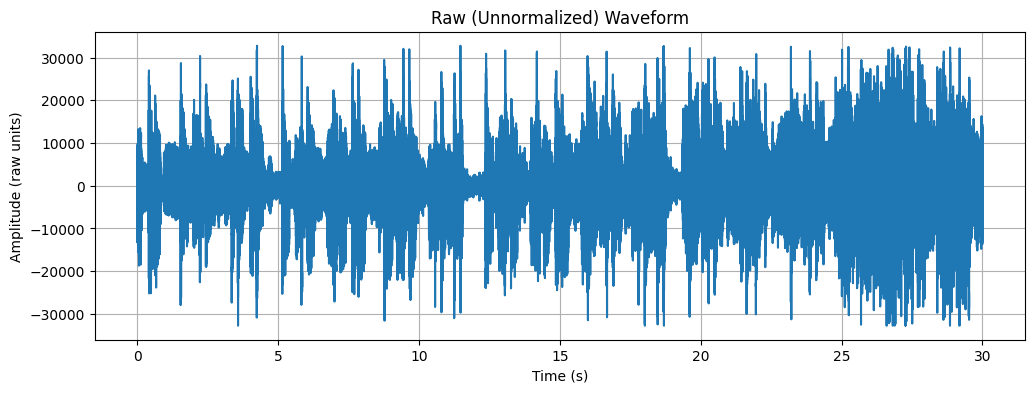

In [15]:
import soundfile as sf
import matplotlib.pyplot as plt
import numpy as np

# === 讀取原始音訊，不經正規化 ===
file_paths = "C:\\Users\\user\\Desktop\\碩士二年級\\Python\\論文CODE\\Data\\test\\jazz\\jazz.00000.wav"
y, sr = sf.read(file_path, dtype='int16', always_2d=False)

print(y.dtype)  # 檢查型態 (例如 int16)
print(f"範圍: {y.min()} ~ {y.max()}")

# === 繪製波形 ===
duration = len(y) / sr
time = np.linspace(0, duration, len(y))

plt.figure(figsize=(12, 4))
plt.plot(time, y)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (raw units)")
plt.title("Raw (Unnormalized) Waveform")
plt.grid(True)
plt.show()

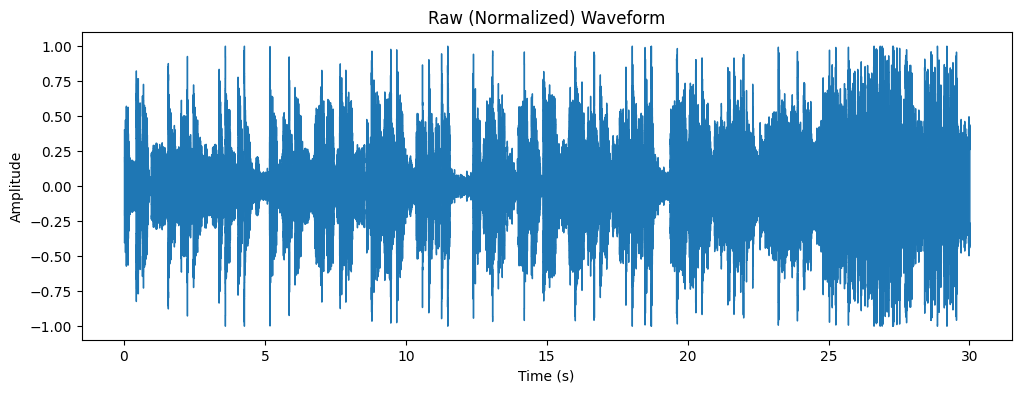

In [16]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

y, sr = librosa.load(file_path, sr=None)
duration = len(y) / sr

plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, sr=sr)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Raw (Normalized) Waveform")
plt.grid(False)
plt.show()


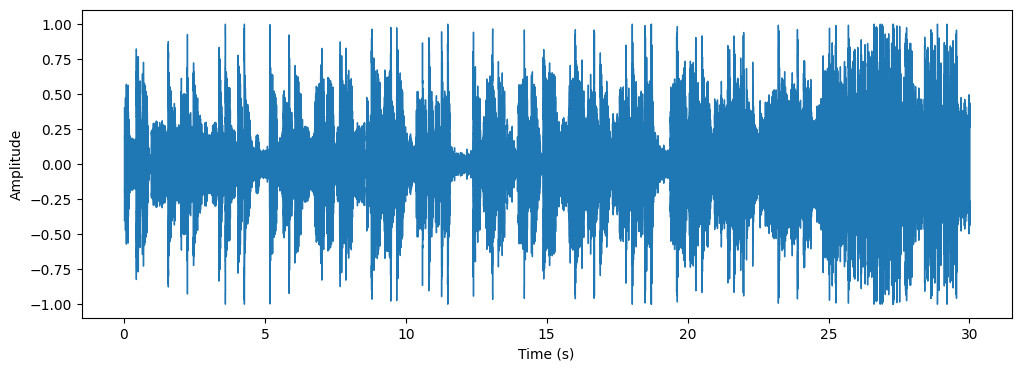

float64
範圍: -1.0 ~ 0.999969482421875


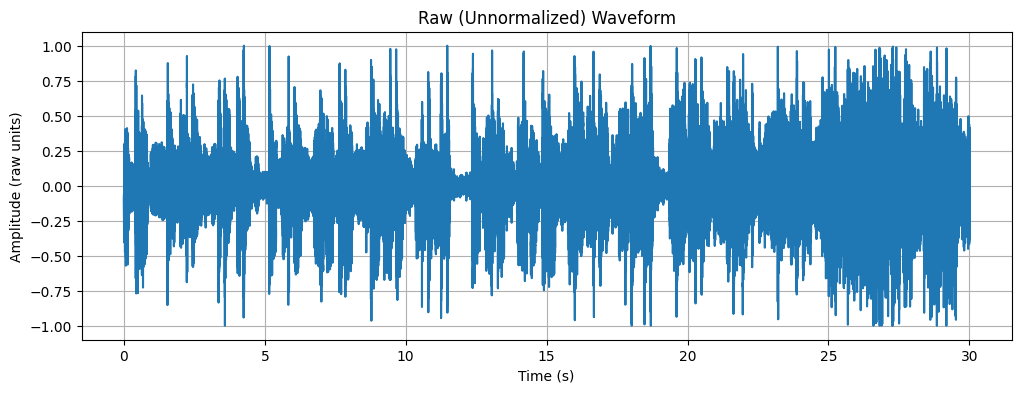

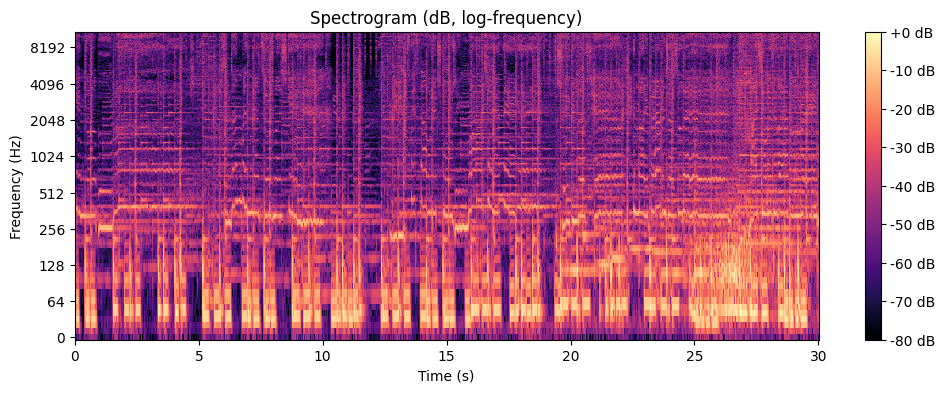

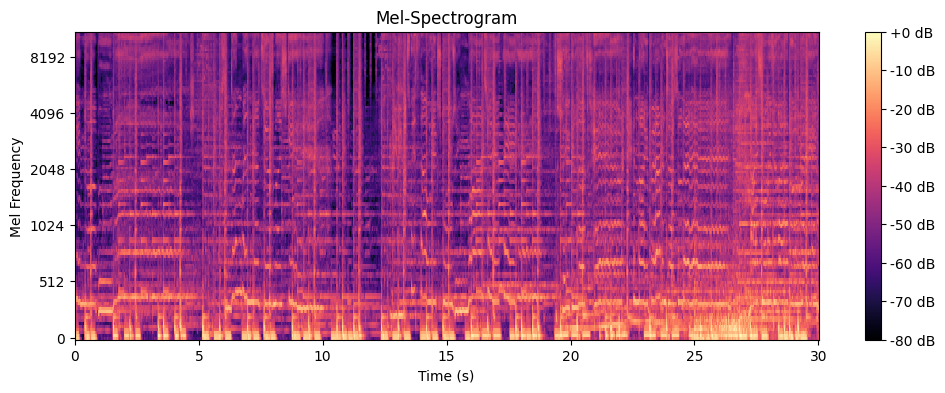

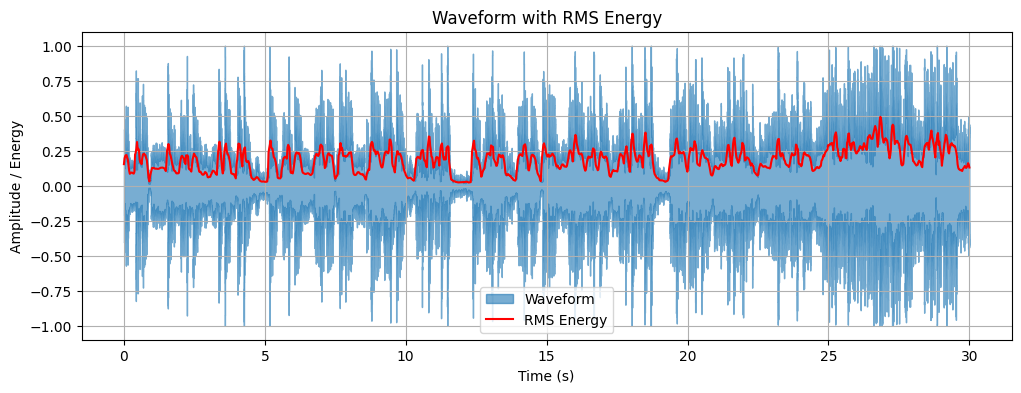

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

y, sr = librosa.load(file_path, sr=None)
duration = len(y) / sr

plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, sr=sr)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Raw (Normalized) Waveform")
plt.grid(False)
plt.show()



import numpy as np

# 轉成功率譜 (Power Spectrogram)
S = np.abs(librosa.stft(y))**2
S_db = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (dB, log-frequency)")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.show()

mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
mel_db = librosa.power_to_db(mel, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(mel_db, sr=sr, x_axis='time', y_axis='mel', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title("Mel-Spectrogram")
plt.xlabel("Time (s)")
plt.ylabel("Mel Frequency")
plt.show()

rms = librosa.feature.rms(y=y)[0]
times = librosa.times_like(rms, sr=sr)

plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, sr=sr, alpha=0.6, label="Waveform")
plt.plot(times, rms, color='r', label="RMS Energy")
plt.title("Waveform with RMS Energy")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude / Energy")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# === 自訂函式：計算 swing features ===
# 確保你已經定義 extract_swing_features(y_segment, sr)
# def extract_swing_features(y_segment, sr):
#     ...
#     return [swing_mean, swing_var, rms_mean, rms_var]

# === 音檔路徑及標籤 ===
file_paths = [
    "C:\\Users\\user\\Desktop\\碩士二年級\\Python\\論文CODE\\Data\\test\\jazz\\jazz.00000.wav",
    "C:\\Users\\user\\Desktop\\碩士二年級\\Python\\論文CODE\\Data\\test\\pop\\pop.00000.wav"
]
labels = ["Jazz", "Pop"]

# === 迭代分析每個檔案 ===
for file_path, label in zip(file_paths, labels):
    # --- 讀取音檔 ---
    y, sr = librosa.load(file_path, sr=None)
    duration = len(y) / sr
    
    # --- Spectral Centroid ---
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    centroid_time = np.linspace(0, duration, len(centroid))
    plt.figure(figsize=(12,4))
    plt.plot(centroid_time, centroid, color='r')
    plt.title(f"Spectral Centroid - {label}")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.grid(True)
    plt.show()
    
    # --- Spectral Rolloff ---
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]
    rolloff_time = np.linspace(0, duration, len(rolloff))
    plt.figure(figsize=(12,4))
    plt.plot(rolloff_time, rolloff, color='g')
    plt.title(f"Spectral Rolloff - {label}")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.grid(True)
    plt.show()
    
    # --- Zero Crossing Rate ---
    zcr = librosa.feature.zero_crossing_rate(y=y)[0]
    zcr_time = np.linspace(0, duration, len(zcr))
    plt.figure(figsize=(12,4))
    plt.plot(zcr_time, zcr, color='b')
    plt.title(f"Zero Crossing Rate - {label}")
    plt.xlabel("Time (s)")
    plt.ylabel("Rate (0~1)")
    plt.grid(True)
    plt.show()
    
    # --- RMS ---
    rms = librosa.feature.rms(y=y)[0]
    rms_time = np.linspace(0, duration, len(rms))
    plt.figure(figsize=(12,4))
    plt.plot(rms_time, rms, color='m')
    plt.title(f"RMS Energy - {label}")
    plt.xlabel("Time (s)")
    plt.ylabel("RMS")
    plt.grid(True)
    plt.show()
    
    # --- MFCC ---
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    n_mfcc = mfcc.shape[0]
    n_mels = 128
    mel_frequencies = librosa.mel_frequencies(n_mels=n_mels, fmin=0, fmax=sr/2)
    mfcc_freqs = np.linspace(mel_frequencies[0], mel_frequencies[-1], n_mfcc)
    
    plt.figure(figsize=(12,4))
    librosa.display.specshow(mfcc, x_axis='time', sr=sr)
    plt.colorbar()
    plt.title(f"MFCC (First 13 Coefficients) - {label}")
    plt.xlabel("Time (s)")
    plt.ylabel("Approx. Frequency (Hz)")
    plt.yticks(np.arange(n_mfcc), [f"{int(f)}" for f in mfcc_freqs])
    plt.tight_layout()
    plt.show()
    
    # --- Swing Ratio ---
    texture_window = 1.0
    overlap = 0.2
    texture_len = int(texture_window * sr)
    hop_len = int((texture_window - overlap) * sr)
    
    # swing_means = []
    # for start in range(0, len(y) - texture_len + 1, hop_len):
    #     segment = y[start:start + texture_len]
    #     swing_feats = extract_swing_features(segment, sr)
    #     swing_means.append(swing_feats[0])
    
    # n_windows = len(swing_means)
    # time_axis = np.arange(n_windows) * (texture_window - overlap)
    
    # plt.figure(figsize=(12,4))
    # plt.plot(time_axis, swing_means, marker='o', color='orange')
    # plt.title(f"Swing Ratio Over Time - {label}")
    # plt.xlabel("Time (s)")
    # plt.ylabel("Swing Mean")
    # plt.grid(True)
    # plt.show()
    
    # swing_matrix = np.array(swing_means).reshape(1, -1)
    # plt.figure(figsize=(12,2))
    # sns.heatmap(swing_matrix, cmap="Reds", cbar_kws={'label': 'Swing Ratio'})
    # plt.xlabel("Texture Window")
    # plt.title(f"Swing Ratio Heatmap - {label}")
    # plt.show()


c:\Users\user\anaconda3\envs\py310\lib\site-packages\librosa\feature\spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


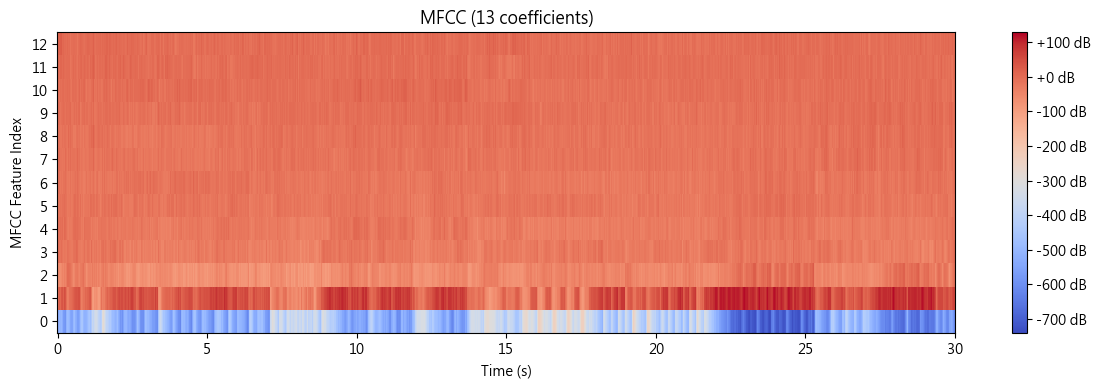

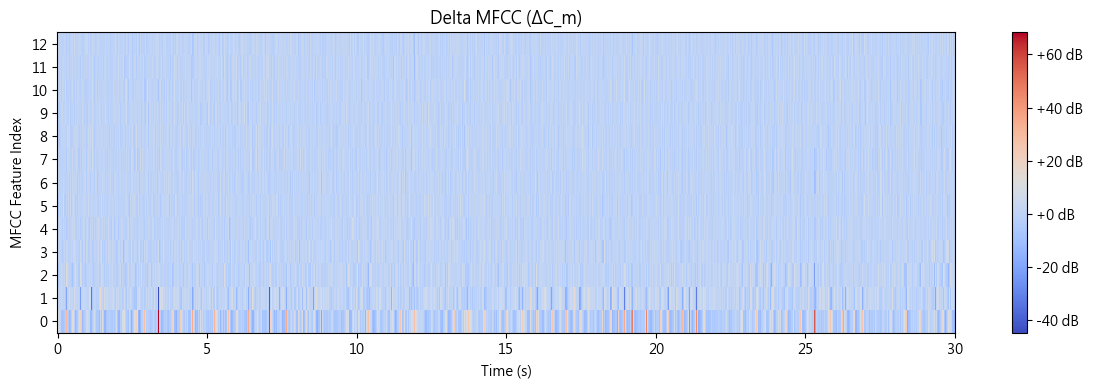

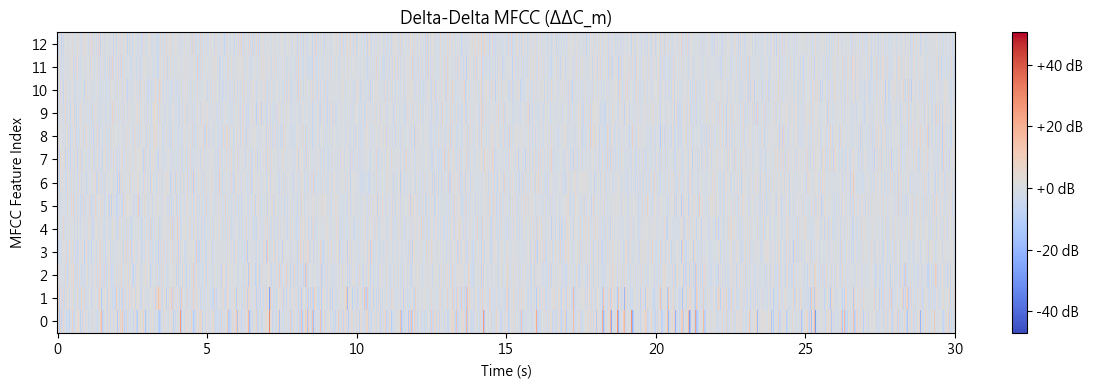

In [22]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

# --- 讀取音訊 ---
file_path = "C:\\Users\\user\\Desktop\\碩士二年級\\Python\\論文CODE\\Data\\test\\jazz\\jazz.00000.wav"
y, sr = librosa.load(file_path, sr=None)

# --- 預強調 ---
pre_emphasis = 0.97
y_preemphasized = np.append(y[0], y[1:] - pre_emphasis * y[:-1])

# --- MFCC 計算 ---
n_mfcc = 13
mfcc = librosa.feature.mfcc(y=y_preemphasized, sr=sr, n_mfcc=n_mfcc,
                            n_fft=512, hop_length=256, htk=True)
delta_mfcc = librosa.feature.delta(mfcc, width=5, order=1)
delta2_mfcc = librosa.feature.delta(mfcc, width=5, order=2)

def plot_mfcc_with_index(feature_matrix, title):
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(feature_matrix, x_axis='time', sr=sr, hop_length=256)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.xlabel("Time (s)")
    
    # Y 軸標示每個特徵序號（第 1~N 個）
    n_coeffs = feature_matrix.shape[0]
    plt.yticks(np.arange(n_coeffs), [f"{i}" for i in range(n_coeffs)])
    plt.ylabel("MFCC Feature Index")
    
    plt.tight_layout()
    plt.show()

# 繪圖
plot_mfcc_with_index(mfcc, "MFCC (13 coefficients)")
plot_mfcc_with_index(delta_mfcc, "Delta MFCC (ΔC_m)")
plot_mfcc_with_index(delta2_mfcc, "Delta-Delta MFCC (ΔΔC_m)")


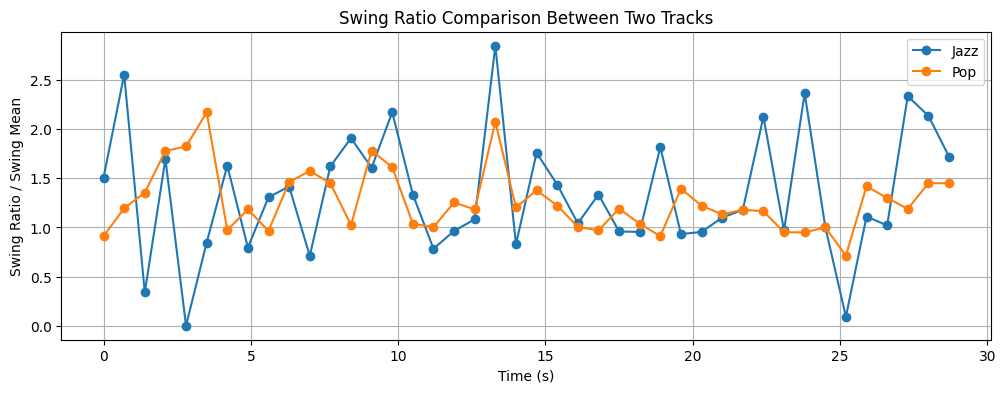

In [21]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

# === 音檔路徑 ===
file_paths = [
    "C:\\Users\\user\\Desktop\\碩士二年級\\Python\\論文CODE\\Data\\test\\jazz\\jazz.00000.wav",
    "C:\\Users\\user\\Desktop\\碩士二年級\\Python\\論文CODE\\Data\\test\\pop\\pop.00000.wav"
]
labels = ["Jazz", "Pop"]

# === 參數設定 ===
texture_window = 1.0
overlap = 0.3

plt.figure(figsize=(12,4))

for file_path, label in zip(file_paths, labels):
    # 讀取音檔
    y, sr = librosa.load(file_path, sr=None)
    
    texture_len = int(texture_window * sr)
    hop_len = int((texture_window - overlap) * sr)
    
    # 計算每段 swing_mean
    swing_means = []
    for start in range(0, len(y) - texture_len + 1, hop_len):
        segment = y[start:start + texture_len]
        swing_feats = extract_swing_features(segment, sr)  # 自訂函式
        swing_means.append(swing_feats[0])
    
    # 時間軸
    n_windows = len(swing_means)
    time_axis = np.arange(n_windows) * (texture_window - overlap)
    
    # 畫折線
    plt.plot(time_axis, swing_means, marker='o', label=label)

plt.xlabel("Time (s)")
plt.ylabel("Swing Ratio / Swing Mean")
plt.title("Swing Ratio Comparison Between Two Tracks")
plt.legend()
plt.grid(True)
plt.show()


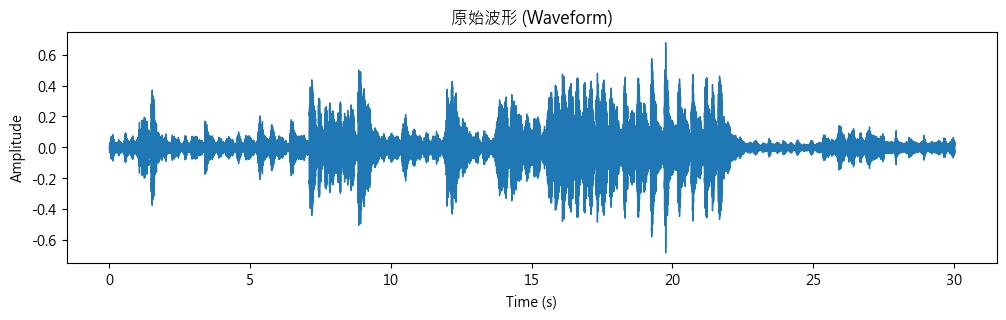

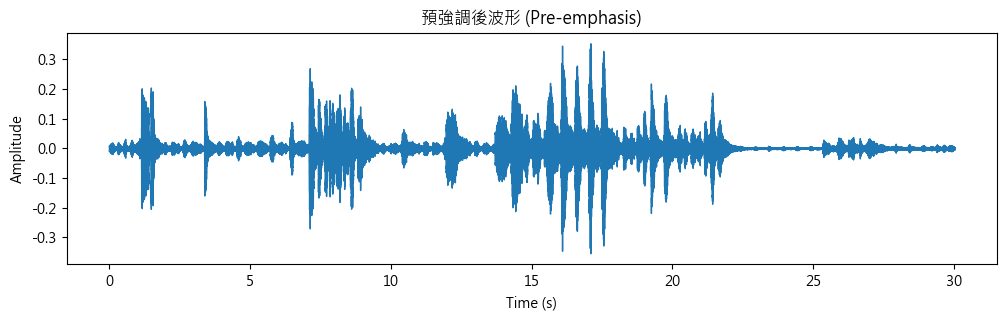

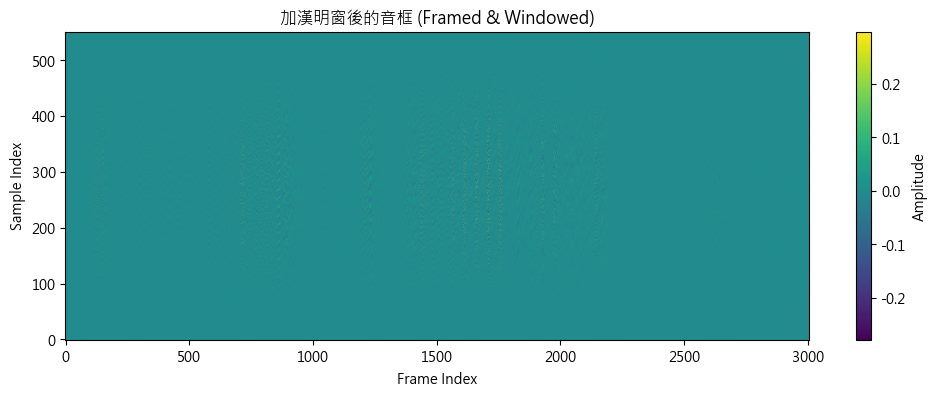

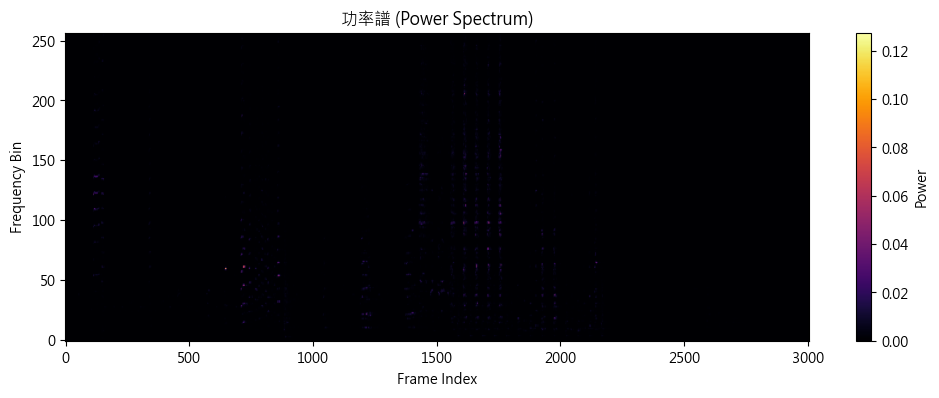

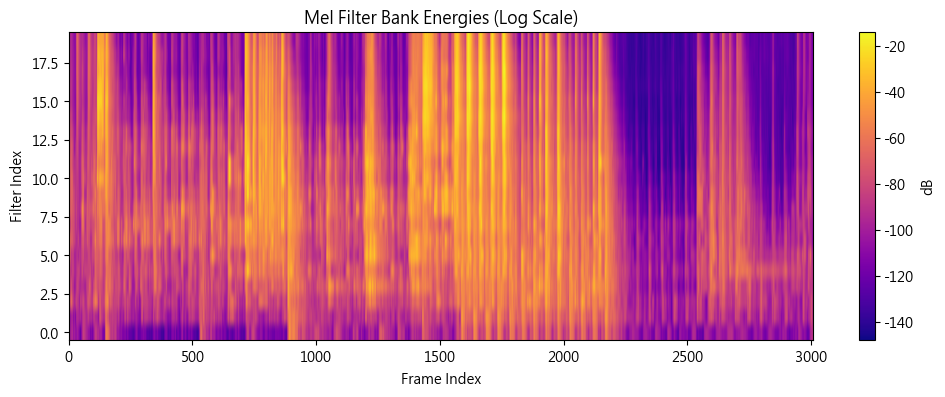

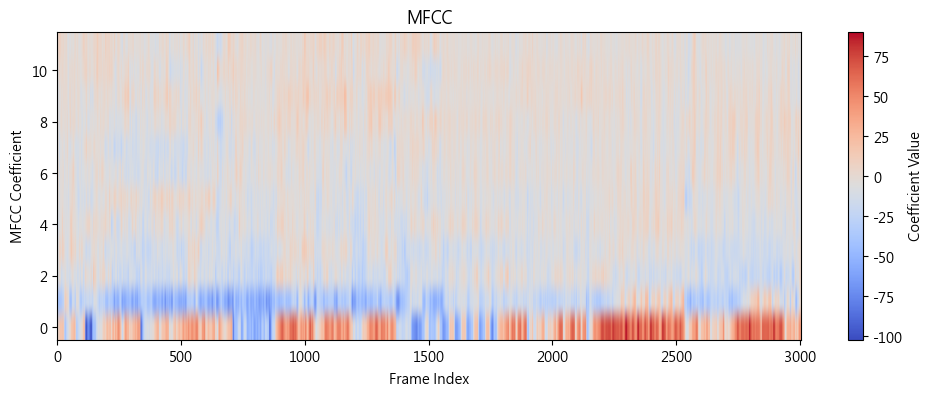

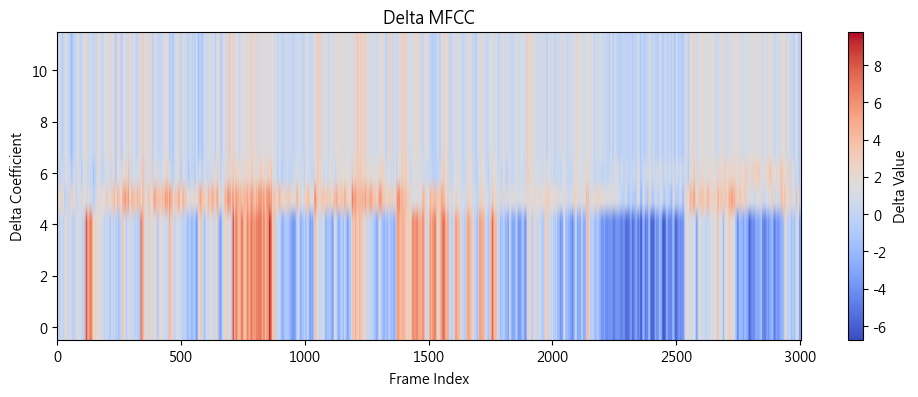

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from scipy.fftpack import dct
from matplotlib import rcParams
rcParams['font.sans-serif'] = ['Microsoft JhengHei']  # 微軟正黑體，Windows 常用
rcParams['axes.unicode_minus'] = False  # 避免負號顯示成方框

# === 讀取音訊 ===
file_path = "C:\\Users\\user\\Desktop\\碩士二年級\\Python\\論文CODE\\Data\\test\\jazz\\jazz.00000.wav"
y, sr = librosa.load(file_path, sr=None)

# --- 1. 原始波形 ---
plt.figure(figsize=(12,3))
librosa.display.waveshow(y, sr=sr)
plt.title("原始波形 (Waveform)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

# --- 2. 預強調 ---
pre_emphasis = 0.97
y_preemph = np.append(y[0], y[1:] - pre_emphasis * y[:-1])
plt.figure(figsize=(12,3))
librosa.display.waveshow(y_preemph, sr=sr)
plt.title("預強調後波形 (Pre-emphasis)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

# --- 3. 分幀 + 漢明窗 ---
frame_size = 0.025  # 25 ms
frame_stride = 0.01 # 10 ms
frame_length = int(round(frame_size * sr))
frame_step = int(round(frame_stride * sr))
signal_length = len(y_preemph)
num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step)) + 1

pad_signal_length = num_frames * frame_step + frame_length
z = np.zeros((pad_signal_length - signal_length))
pad_signal = np.append(y_preemph, z)

indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + \
          np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(np.int32, copy=False)]

# 漢明窗
frames *= np.hamming(frame_length)

plt.figure(figsize=(12,4))
plt.imshow(frames.T, aspect='auto', origin='lower', cmap='viridis')
plt.title("加漢明窗後的音框 (Framed & Windowed)")
plt.xlabel("Frame Index")
plt.ylabel("Sample Index")
plt.colorbar(label="Amplitude")
plt.show()

# --- 4. FFT & 功率譜 ---
NFFT = 512
mag_frames = np.absolute(np.fft.rfft(frames, NFFT))
pow_frames = ((1.0 / NFFT) * (mag_frames ** 2))

plt.figure(figsize=(12,4))
plt.imshow(pow_frames.T, aspect='auto', origin='lower', cmap='inferno')
plt.title("功率譜 (Power Spectrum)")
plt.xlabel("Frame Index")
plt.ylabel("Frequency Bin")
plt.colorbar(label="Power")
plt.show()

# --- 5. Mel Filter Bank ---
nfilt = 20
low_freq_mel = 0
high_freq_mel = 2595 * np.log10(1 + (sr/2)/700)
mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)
hz_points = 700 * (10**(mel_points/2595) - 1)
bin = np.floor((NFFT + 1) * hz_points / sr)

fbank = np.zeros((nfilt, int(np.floor(NFFT/2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])
    f_m = int(bin[m])
    f_m_plus = int(bin[m + 1])
    for k in range(f_m_minus, f_m):
        fbank[m-1, k] = (k - bin[m-1]) / (bin[m] - bin[m-1])
    for k in range(f_m, f_m_plus):
        fbank[m-1, k] = (bin[m+1] - k) / (bin[m+1] - bin[m])

filter_banks = np.dot(pow_frames, fbank.T)
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
filter_banks = 20 * np.log10(filter_banks)

plt.figure(figsize=(12,4))
plt.imshow(filter_banks.T, aspect='auto', origin='lower', cmap='plasma')
plt.title("Mel Filter Bank Energies (Log Scale)")
plt.xlabel("Frame Index")
plt.ylabel("Filter Index")
plt.colorbar(label="dB")
plt.show()

# --- 6. DCT → MFCC ---
num_ceps = 12
mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps+1)]

plt.figure(figsize=(12,4))
plt.imshow(mfcc.T, aspect='auto', origin='lower', cmap='coolwarm')
plt.title("MFCC")
plt.xlabel("Frame Index")
plt.ylabel("MFCC Coefficient")
plt.colorbar(label="Coefficient Value")
plt.show()

# --- 7. Delta MFCC ---
delta_mfcc = librosa.feature.delta(mfcc)
plt.figure(figsize=(12,4))
plt.imshow(delta_mfcc.T, aspect='auto', origin='lower', cmap='coolwarm')
plt.title("Delta MFCC")
plt.xlabel("Frame Index")
plt.ylabel("Delta Coefficient")
plt.colorbar(label="Delta Value")
plt.show()


### Swing Ratio

Loaded: C:\Users\user\Desktop\碩士二年級\Python\論文CODE\Data\genres_original\jazz\jazz.00099.wav
Estimated Swing Ratio = 0.11255091845524794


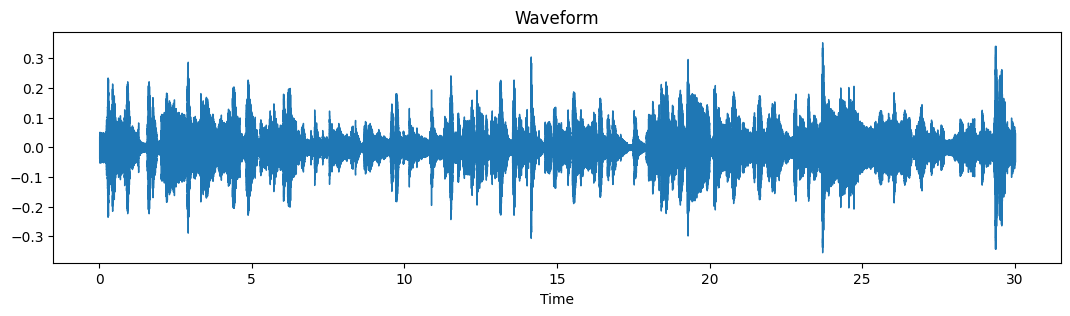

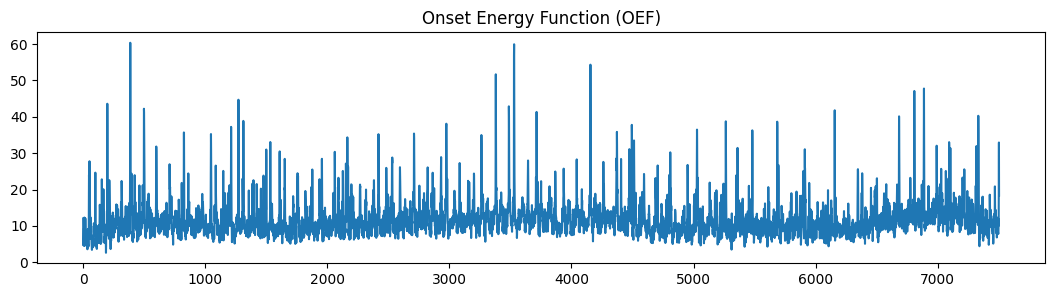

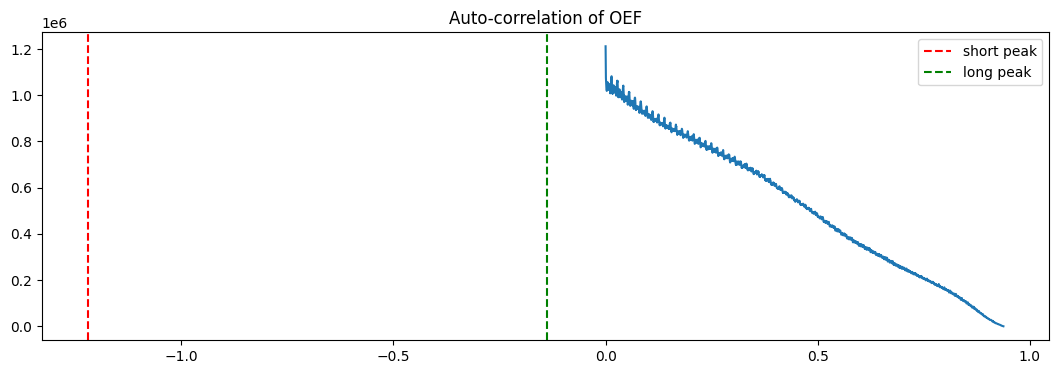

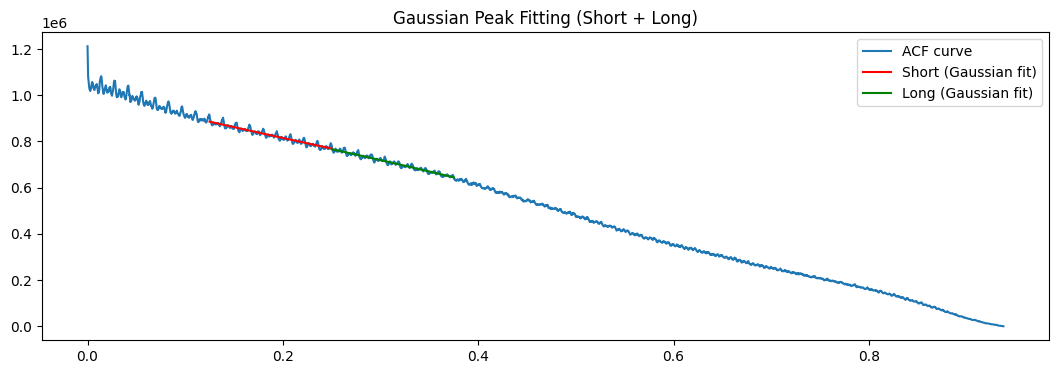

In [3]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate
from scipy.optimize import curve_fit

# ==========================================================
# 0. 載入音訊
# ==========================================================
file = r"C:\Users\user\Desktop\碩士二年級\Python\論文CODE\Data\genres_original\jazz\jazz.00099.wav"
y, sr = librosa.load(file, sr=8000)   # 依照論文使用 8kHz
print("Loaded:", file)

# ==========================================================
# 1. Onset Energy Function（OEF）
# ==========================================================
# Mel spectrogram
S = np.abs(librosa.stft(y, n_fft=256, hop_length=32))
mel = librosa.feature.melspectrogram(S=S, sr=sr, n_mels=40)
mel_db = librosa.power_to_db(mel)

# 時間差分 → onset energy
diff = np.diff(mel_db, axis=1)
diff = np.maximum(0, diff)  # 只取正向能量
oef = np.sum(diff, axis=0)

# 平滑
oef_smooth = librosa.effects.harmonic(oef)

# ==========================================================
# 2. Auto-correlation of OEF
# ==========================================================
acf = correlate(oef_smooth, oef_smooth, mode='full')
acf = acf[len(acf)//2:]  # 只取正延遲

lags = np.arange(len(acf)) / sr

# ==========================================================
# 3. Peak fitting（Gaussian）
# ==========================================================
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2*sigma**2))

# 假設 tempo，以 120 BPM 當示範（你可改成自動估計）
tempo = 120  
quarter = 60 / tempo
eighth = quarter / 2   # de

# 搜尋區域
short_min, short_max = eighth/2, eighth
long_min,  long_max  = eighth, 3*eighth/2

# 從 ACF 找區域
def extract_region(x, y, xmin, xmax):
    idx = np.where((x >= xmin) & (x <= xmax))[0]
    return x[idx], y[idx]

# Fit short
x_s, y_s = extract_region(lags, acf, short_min, short_max)
popt_s, _ = curve_fit(gaussian, x_s, y_s, p0=[max(y_s), x_s[np.argmax(y_s)], 0.02])
As, mus, sigs = popt_s

# Fit long
x_l, y_l = extract_region(lags, acf, long_min, long_max)
popt_l, _ = curve_fit(gaussian, x_l, y_l, p0=[max(y_l), x_l[np.argmax(y_l)], 0.02])
Al, mul, sigl = popt_l

# ==========================================================
# 4. Swing Ratio
# ==========================================================
swing_ratio = mul / mus
print("Estimated Swing Ratio =", swing_ratio)

# ==========================================================
# 5. Visualization
# ==========================================================

plt.figure(figsize=(13,3))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform")
plt.show()

plt.figure(figsize=(13,3))
plt.plot(oef_smooth)
plt.title("Onset Energy Function (OEF)")
plt.show()

plt.figure(figsize=(13,4))
plt.plot(lags, acf)
plt.axvline(mus, color='red', linestyle='--', label='short peak')
plt.axvline(mul, color='green', linestyle='--', label='long peak')
plt.title("Auto-correlation of OEF")
plt.legend()
plt.show()

plt.figure(figsize=(13,4))
plt.plot(lags, acf, label="ACF curve")
plt.plot(x_s, gaussian(x_s, *popt_s), 'r-', label='Short (Gaussian fit)')
plt.plot(x_l, gaussian(x_l, *popt_l), 'g-', label='Long (Gaussian fit)')
plt.title("Gaussian Peak Fitting (Short + Long)")
plt.legend()
plt.show()


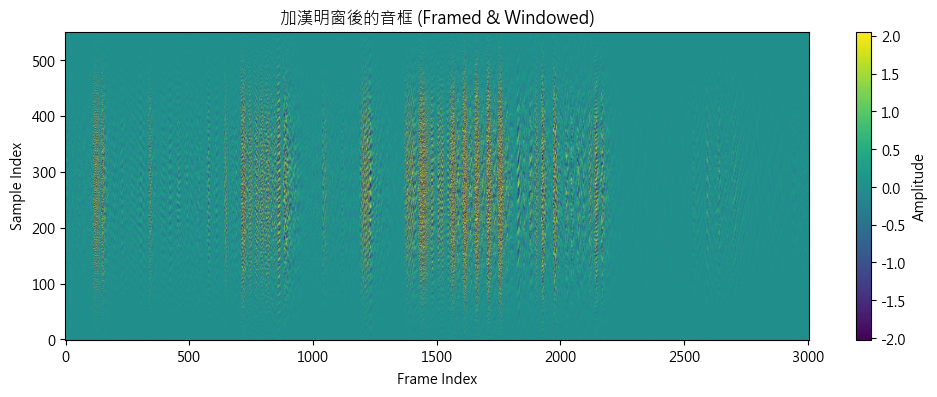

frames 最大值: 14.868981310533258
frames 最小值: -13.909356758894798
frames 平均值: -0.0007826623395540336
frames 標準差: 0.634389648319546


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import librosa

# === 讀取音訊 ===
file_path = "C:\\Users\\user\\Desktop\\碩士二年級\\Python\\論文CODE\\Data\\test\\jazz\\jazz.00000.wav"
y, sr = librosa.load(file_path, sr=None)

# === 1. 放大原始信號振幅 (避免太小) ===
amplify_factor = 5.0
y = y * amplify_factor

# === 2. 預加重 ===
preemph = 0.97
y_preemph = np.append(y[0], y[1:] - preemph * y[:-1])

# === 3. 分幀 + 漢明窗 ===
frame_size = 0.025  # 25 ms
frame_stride = 0.01 # 10 ms
frame_length = int(round(frame_size * sr))
frame_step = int(round(frame_stride * sr))
signal_length = len(y_preemph)
num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step)) + 1

# Padding
pad_signal_length = num_frames * frame_step + frame_length
z = np.zeros((pad_signal_length - signal_length))
pad_signal = np.append(y_preemph, z)

# 取每個幀
indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + \
          np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(np.int32, copy=False)]

# 加漢明窗
frames *= np.hamming(frame_length)

# === 4. 選擇性：放大每個幀細節 (可選) ===
frames *= 10  # 放大 10 倍，避免顏色過於單調

# === 5. 畫熱圖，自動縮放顏色 ===
plt.figure(figsize=(12, 4))
vmin = np.percentile(frames, 1)
vmax = np.percentile(frames, 99)

plt.imshow(
    frames.T, 
    aspect='auto', 
    origin='lower', 
    cmap='viridis',
    vmin=vmin,
    vmax=vmax
)
plt.title("加漢明窗後的音框 (Framed & Windowed)")
plt.xlabel("Frame Index")
plt.ylabel("Sample Index")
plt.colorbar(label="Amplitude")
plt.show()

# === 6. 檢查數值範圍 ===
print("frames 最大值:", np.max(frames))
print("frames 最小值:", np.min(frames))
print("frames 平均值:", np.mean(frames))
print("frames 標準差:", np.std(frames))


### 新增 PCA流程 (取 PC1~PC35)

- 在每個 texture window 內，每 0.5 秒取一個長度為 0.1 秒的 analysis window（其餘 0.4 秒不取）。對所有取得的 analysis windows 計算分析特徵，然後回傳 mean + var。

- PCA 解釋變異 : 90%，PC1~PC35

特徵 : SC(1x2)、SR(1x2)、ZCR(1x2)、MFCC(13x2)、Swing(2x2)

-- Spectral Centroid : 1 個頻譜中心特徵 × 2 統計量（mean, variance）

-- Spectral Rolloff : 1 個頻譜衰減特徵 × 2 統計量（mean, variance）

-- Zero Crossing Rate : 1 個零交叉率特徵 × 2 統計量（mean, variance）

-- Mel-Frequency Cepstral Coefficients : 13 個 MFCC × 2 統計量（mean, variance）

-- Swing（節奏與動態特徵）: 4 個特徵（swing_ratio_mean, swing_ratio_var, rms_mean, rms_var）

=== Monte Carlo Summary (5 times)===<br><br>
Mean Accuracy : 0.8600<br>
Std Accuracy : 0.0490<br>

In [2]:
import os
import platform
import librosa
import numpy as np
import pywt
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm
from multiprocessing import cpu_count
import random

# --- 平行運算選擇 ---
if platform.system() == "Windows":
    from multiprocessing.dummy import Pool  # Windows 多執行緒
else:
    from multiprocessing import Pool        # Linux/macOS 多進程


# --- 參數設定 ---
# DATASET_PATH = "C:\\Users\\user\\Desktop\\碩士二年級\\Python\\論文CODE\\Data\\genres_original"
# DATASET_PATH = "C:\\Users\\user\\Desktop\\碩士二年級\\Python\\論文CODE\\Data\\test"
DATASET_PATH = "C:\\Users\\user\\Desktop\\碩士二年級\\Python\\論文CODE\\Data\\genres_original"
genres = ['blues', 'classical', 'jazz', 'pop', 'rock']

    # === 參數設定 ===
texture_window = 3.0
analysis_window = 0.1     # 每個分析子區段長度（0.1 秒）
hop_duration = 0.5        # 每 0.5 秒取一次分析
overlap = 0.2
n_iterations = 5
test_size = 0.2

# analysis_hop = 0.05
# n_analysis_windows = 20

# === Swing 特徵 ===
def extract_swing_features(y, sr):
    try:
        tempo, beats = librosa.beat.beat_track(y=y, sr=sr)
        onsets = librosa.onset.onset_detect(y=y, sr=sr, units='time')
        if len(onsets) < 3:
            return np.zeros(4)
        intervals = np.diff(onsets)
        ratios = intervals[1:] / (intervals[:-1] + 1e-6)
        swing_mean = np.mean(ratios)
        swing_var = np.var(ratios)
        rms = librosa.feature.rms(y=y)[0]
        rms_mean = np.mean(rms)
        rms_var = np.var(rms)
        return np.array([swing_mean, swing_var, rms_mean, rms_var])
    except Exception:
        return np.zeros(4)

# # === DWCH 特徵 ===
# def extract_DWCH_features(y, n=10, wavelet='db4', level=4):
#     try:
#         coeffs = pywt.wavedec(y, wavelet=wavelet, level=level)
#         feature_vector = []
#         for band in coeffs:
#             band = np.nan_to_num(band)
#             hist, _ = np.histogram(band, bins=n, density=True)
#             mean_val = np.mean(band)
#             var_val = np.var(band)
#             skew_val = skew(band)
#             energy_val = np.sum(band ** 2)
#             band_features = np.concatenate(([mean_val, var_val, skew_val, energy_val], hist))
#             feature_vector.extend(band_features)
#         return np.array(feature_vector)
#     except Exception:
#         return np.zeros((4 + n) * level)

# === Analysis window 特徵 ===
def extract_analysis_features(y_segment, sr):
    # centroid, rolloff, zcr
    centroid = librosa.feature.spectral_centroid(y=y_segment, sr=sr)[0]
    rolloff = librosa.feature.spectral_rolloff(y=y_segment, sr=sr)[0]
    zcr = librosa.feature.zero_crossing_rate(y=y_segment)[0]

    feats = {
        'centroid_mean': np.mean(centroid),
        'centroid_var': np.var(centroid),
        'rolloff_mean': np.mean(rolloff),
        'rolloff_var': np.var(rolloff),
        'zcr_mean': np.mean(zcr),
        'zcr_var': np.var(zcr)
    }
    return feats


def extract_features_from_segment(y_segment, sr):
    hop_len = int(hop_duration * sr)
    analysis_len = int(analysis_window * sr)
    total_len = len(y_segment)

    # === 計算 hop 起點 ===
    starts = np.arange(0, max(total_len - hop_len + 1, 1), hop_len, dtype=int)
    analysis_features_list = []

    for start in starts:
        # 在 [start, start + hop_len] 之間隨機選擇 0.1 秒子片段
        if start + hop_len < total_len:
            rand_offset = random.randint(0, max(hop_len - analysis_len, 1))
        else:
            rand_offset = 0  # 最後不足 hop_len 的部分就取開頭

        seg_start = start + rand_offset
        seg_end = seg_start + analysis_len
        if seg_end > total_len:
            seg_end = total_len

        subseg = y_segment[seg_start:seg_end]
        feats = extract_analysis_features(subseg, sr)
        analysis_features_list.append(feats)

    # === 對整個 texture window 的分析平均 ===
    all_feats = {}
    for key in analysis_features_list[0].keys():
        values = np.array([f[key] for f in analysis_features_list])
        all_feats[key] = np.mean(values, axis=0)

    # === 對整段 texture window 直接計算高階特徵 ===
    mfcc = librosa.feature.mfcc(y=y_segment, sr=sr, n_mfcc=13)
    swing_feats = extract_swing_features(y_segment, sr)

    all_feats['mfcc_mean'] = np.mean(mfcc, axis=1)
    all_feats['mfcc_var']  = np.var(mfcc, axis=1)
    all_feats['swing_mean'] = swing_feats[0]
    all_feats['swing_var']  = swing_feats[1]
    all_feats['rms_mean']   = swing_feats[2]
    all_feats['rms_var']    = swing_feats[3]

    # === 合併成單一 feature vector ===
    final_feats = np.hstack(list(all_feats.values()))
    return final_feats

def process_audio_file(file_path):
    y, sr = librosa.load(file_path, sr=22050)  # 可固定取樣率以一致化特徵
    texture_samples = int(texture_window * sr)     # 3 秒
    hop_samples = int((texture_window - overlap) * sr)  # 重疊 0.5 秒 → hop = 2.5 秒

    features = []
    total_len = len(y)

    # 以 3 秒為單位滑動（重疊 0.5 秒）
    for start in range(0, max(total_len - texture_samples + 1, 1), hop_samples):
        segment = y[start:start + texture_samples]
        feats = extract_features_from_segment(segment, sr)
        features.append(feats)
    return np.array(features)

# === 平行提取 ===
def parallel_feature_extraction(file_label_pairs):
    features, labels = [], []
    for file_path, label in file_label_pairs:
        feats = process_audio_file(file_path)
        for f in feats:
            features.append(f)
            labels.append(label)
    return features, labels

def most_common_label(arr):
    values, counts = np.unique(arr, return_counts=True)
    return values[np.argmax(counts)]

# === 主程式 ===
if __name__ == "__main__":
    _ = librosa.hz_to_note(440.0)
    all_files, all_labels = [], []
    for genre in genres:
        genre_path = os.path.join(DATASET_PATH, genre)
        files = [os.path.join(genre_path, f) for f in os.listdir(genre_path) if f.endswith('.wav')]
        all_files.extend(files)
        all_labels.extend([genre] * len(files))

    all_files = np.array(all_files)
    all_labels = np.array(all_labels)
    
    all_files_cleaned = []
    for f in all_files:
        try:
            y, sr = librosa.load(f, sr=None)
            all_files_cleaned.append(f)  # 成功讀取才加入清單
        except Exception as e:
            print(f" 無法讀取檔案: {f}")
            try:
                os.remove(f)
                print(f"🗑 已刪除檔案: {f}\n")
            except Exception as del_err:
                print(f" 無法刪除檔案: {f}, 原因: {del_err}\n")

    all_files = all_files_cleaned
    print(f"Total files: {len(all_files)}")

    acc_scores = []

    for iteration in range(1, n_iterations + 1):
        print(f"\n=== Monte Carlo Iteration {iteration} ===")

        train_files, test_files, train_labels, test_labels = train_test_split(
            all_files, all_labels, test_size=test_size, stratify=all_labels, random_state=iteration
        )

        print(f"Training samples: {len(train_files)}, Testing samples: {len(test_files)}")

        # === 提取訓練特徵 ===
        chunk_size = 10
        train_pairs = list(zip(train_files, train_labels))
        with Pool(processes=cpu_count()) as pool:
            results = list(tqdm(
                pool.imap_unordered(parallel_feature_extraction,
                                    [train_pairs[i:i + chunk_size] for i in range(0, len(train_pairs), chunk_size)]),
                total=max(1, len(train_pairs) // chunk_size)
            ))
        train_features, train_y = [], []
        for f, l in results:
            train_features.extend(f)
            train_y.extend(l)

        X_train = np.array(train_features)
        y_train = np.array(train_y)
        print(f"訓練特徵 shape: {X_train.shape}")


        # === 標準化 ===
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)

        # === 先擬合 PCA，看看累積解釋變異 ===
        pca_full = PCA().fit(X_train_scaled)
        cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

        # 找出最小的 n_components 使得累積解釋率 >= 0.85
        n_components_90 = np.argmax(cumulative_variance >= 0.9) + 1

        print(f" 累積解釋變異率超過 90% 所需主成分數：{n_components_90}")
        print(f"各主成分解釋率：{pca_full.explained_variance_ratio_[:n_components_90]}")
        print(f"累積解釋率：{cumulative_variance[n_components_90-1]:.4f}")

        # === 實際取該數量的主成分再投影 ===
        pca = PCA(n_components=n_components_90)
        X_train_pca = pca.fit_transform(X_train_scaled)

        # === 建立模型 ===
        model = LogisticRegression(max_iter=1000)
        model.fit(X_train_pca, y_train)

        # === 測試階段 ===
        test_preds = []
        print("Processing test files...")
        for fpath in tqdm(test_files):
            feats = process_audio_file(fpath)
            feats = scaler.transform(feats)
            feats_pca = pca.transform(feats)
            segment_preds = model.predict(feats_pca)
            song_pred = most_common_label(segment_preds)
            test_preds.append(song_pred)

        acc = accuracy_score(test_labels, test_preds)
        acc_scores.append(acc)

        print(f"Iteration {iteration} Accuracy: {acc:.4f}")
        print("Confusion Matrix:")
        print(confusion_matrix(test_labels, test_preds))
        print("Classification Report:")
        print(classification_report(test_labels, test_preds))

    print("\n=== Monte Carlo Summary ===")
    print(f"Mean Accuracy: {np.mean(acc_scores):.4f}")
    print(f"Std Accuracy: {np.std(acc_scores):.4f}")


Total files: 499

=== Monte Carlo Iteration 1 ===
Training samples: 399, Testing samples: 100


40it [01:40,  2.52s/it]                        


訓練特徵 shape: (3990, 36)
 累積解釋變異率超過 90% 所需主成分數：20
各主成分解釋率：[0.23995261 0.13513598 0.12004903 0.0631231  0.04986163 0.04627182
 0.03496928 0.03342757 0.02357049 0.01873501 0.01804277 0.01673204
 0.01552425 0.014725   0.01402309 0.01382068 0.01343613 0.0124531
 0.01213383 0.01114701]
累積解釋率：0.9071
Processing test files...


100%|██████████| 100/100 [01:19<00:00,  1.25it/s]


Iteration 1 Accuracy: 0.8200
Confusion Matrix:
[[16  0  1  0  3]
 [ 0 20  0  0  0]
 [ 2  1 15  0  2]
 [ 0  0  0 18  2]
 [ 3  0  3  1 13]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.76      0.80      0.78        20
   classical       0.95      1.00      0.98        20
        jazz       0.79      0.75      0.77        20
         pop       0.95      0.90      0.92        20
        rock       0.65      0.65      0.65        20

    accuracy                           0.82       100
   macro avg       0.82      0.82      0.82       100
weighted avg       0.82      0.82      0.82       100


=== Monte Carlo Iteration 2 ===
Training samples: 399, Testing samples: 100


40it [01:37,  2.43s/it]                        


訓練特徵 shape: (3990, 36)
 累積解釋變異率超過 90% 所需主成分數：20
各主成分解釋率：[0.2583079  0.13274489 0.11585866 0.0622664  0.04933955 0.04619342
 0.03335491 0.03137666 0.02252381 0.01790505 0.01751063 0.0168795
 0.01523835 0.01457032 0.01363461 0.01270961 0.01241191 0.01221683
 0.01149352 0.01118203]
累積解釋率：0.9077
Processing test files...


100%|██████████| 100/100 [00:18<00:00,  5.41it/s]


Iteration 2 Accuracy: 0.8300
Confusion Matrix:
[[18  1  1  0  0]
 [ 0 20  0  0  0]
 [ 1  2 15  0  2]
 [ 0  0  2 16  2]
 [ 5  0  1  0 14]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.75      0.90      0.82        20
   classical       0.87      1.00      0.93        20
        jazz       0.79      0.75      0.77        20
         pop       1.00      0.80      0.89        20
        rock       0.78      0.70      0.74        20

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.84      0.83      0.83       100


=== Monte Carlo Iteration 3 ===
Training samples: 399, Testing samples: 100


40it [01:37,  2.43s/it]                        


訓練特徵 shape: (3990, 36)
 累積解釋變異率超過 90% 所需主成分數：20
各主成分解釋率：[0.25034697 0.12787729 0.12487967 0.06162143 0.04990991 0.04812872
 0.03401708 0.03203541 0.02367343 0.01821618 0.01761619 0.0165951
 0.01533136 0.01497775 0.01384327 0.01325898 0.01259215 0.01235582
 0.01133885 0.01088001]
累積解釋率：0.9095
Processing test files...


100%|██████████| 100/100 [00:18<00:00,  5.43it/s]


Iteration 3 Accuracy: 0.7400
Confusion Matrix:
[[13  0  3  0  4]
 [ 0 19  1  0  0]
 [ 2  2 14  1  1]
 [ 0  0  3 17  0]
 [ 3  1  4  1 11]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.72      0.65      0.68        20
   classical       0.86      0.95      0.90        20
        jazz       0.56      0.70      0.62        20
         pop       0.89      0.85      0.87        20
        rock       0.69      0.55      0.61        20

    accuracy                           0.74       100
   macro avg       0.75      0.74      0.74       100
weighted avg       0.75      0.74      0.74       100


=== Monte Carlo Iteration 4 ===
Training samples: 399, Testing samples: 100


40it [01:42,  2.57s/it]                        


訓練特徵 shape: (3990, 36)
 累積解釋變異率超過 90% 所需主成分數：20
各主成分解釋率：[0.24882116 0.1315762  0.11808922 0.06134179 0.04968969 0.04623434
 0.03580464 0.03312477 0.02348166 0.01845568 0.01765473 0.01670818
 0.0156124  0.01517356 0.01380219 0.01314467 0.01270036 0.01250218
 0.0117288  0.01108741]
累積解釋率：0.9067
Processing test files...


100%|██████████| 100/100 [00:18<00:00,  5.53it/s]


Iteration 4 Accuracy: 0.8100
Confusion Matrix:
[[17  0  0  0  3]
 [ 0 17  3  0  0]
 [ 4  0 15  0  1]
 [ 0  0  0 16  4]
 [ 3  0  1  0 16]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.71      0.85      0.77        20
   classical       1.00      0.85      0.92        20
        jazz       0.79      0.75      0.77        20
         pop       1.00      0.80      0.89        20
        rock       0.67      0.80      0.73        20

    accuracy                           0.81       100
   macro avg       0.83      0.81      0.82       100
weighted avg       0.83      0.81      0.82       100


=== Monte Carlo Iteration 5 ===
Training samples: 399, Testing samples: 100


40it [02:05,  3.15s/it]                        


訓練特徵 shape: (3990, 36)
 累積解釋變異率超過 90% 所需主成分數：20
各主成分解釋率：[0.24801947 0.12958404 0.12263715 0.05998833 0.04943246 0.0466365
 0.03515156 0.03299009 0.02294538 0.01850085 0.01805201 0.01692313
 0.0155936  0.01445769 0.01386352 0.01355409 0.01292142 0.01248666
 0.01170289 0.01129488]
累積解釋率：0.9067
Processing test files...


100%|██████████| 100/100 [00:17<00:00,  5.57it/s]

Iteration 5 Accuracy: 0.7700
Confusion Matrix:
[[17  0  1  0  2]
 [ 0 18  2  0  0]
 [ 1  3 16  0  0]
 [ 0  0  1 17  2]
 [ 8  0  2  1  9]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.65      0.85      0.74        20
   classical       0.86      0.90      0.88        20
        jazz       0.73      0.80      0.76        20
         pop       0.94      0.85      0.89        20
        rock       0.69      0.45      0.55        20

    accuracy                           0.77       100
   macro avg       0.78      0.77      0.76       100
weighted avg       0.78      0.77      0.76       100


=== Monte Carlo Summary ===
Mean Accuracy: 0.7940
Std Accuracy: 0.0338


### 接著觀察特徵貢獻

Total features count: 36
PCA feature count: 36


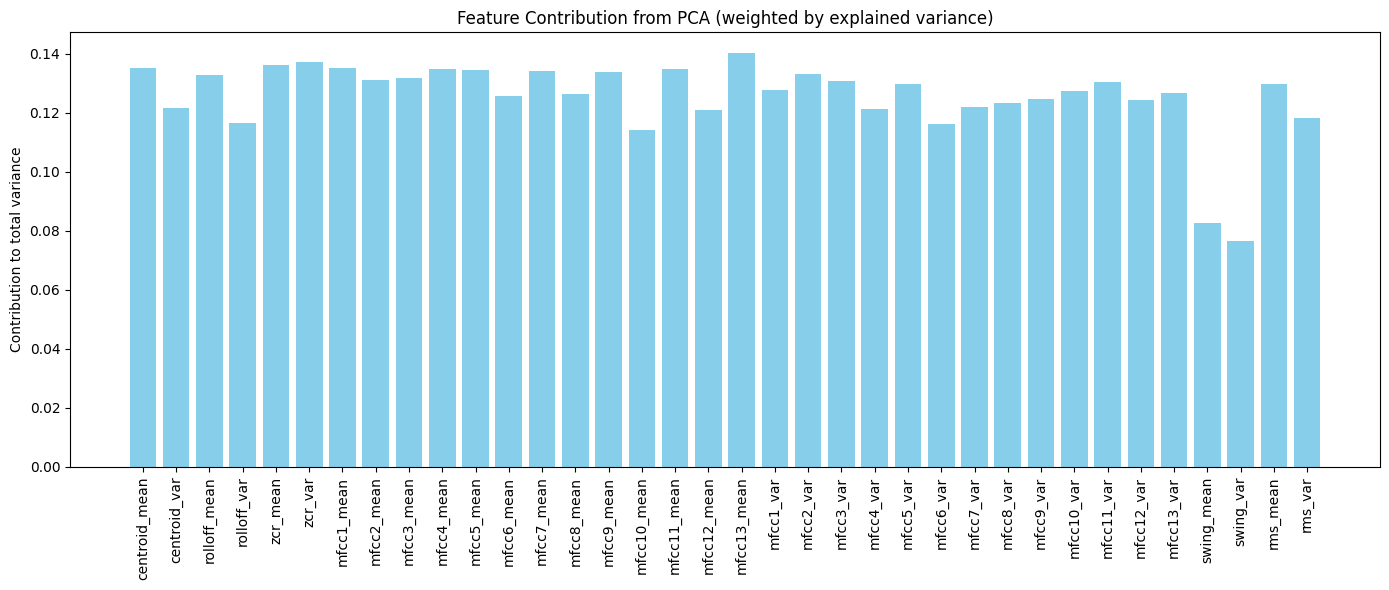


Top 20 features contributing to total variance:
1. mfcc13_mean — contribution: 0.1402
2. zcr_var — contribution: 0.1371
3. zcr_mean — contribution: 0.1360
4. centroid_mean — contribution: 0.1352
5. mfcc1_mean — contribution: 0.1351
6. mfcc11_mean — contribution: 0.1349
7. mfcc4_mean — contribution: 0.1348
8. mfcc5_mean — contribution: 0.1343
9. mfcc7_mean — contribution: 0.1341
10. mfcc9_mean — contribution: 0.1339
11. mfcc2_var — contribution: 0.1333
12. rolloff_mean — contribution: 0.1327
13. mfcc3_mean — contribution: 0.1317
14. mfcc2_mean — contribution: 0.1312
15. mfcc3_var — contribution: 0.1308
16. mfcc11_var — contribution: 0.1303
17. mfcc5_var — contribution: 0.1299
18. rms_mean — contribution: 0.1298
19. mfcc1_var — contribution: 0.1278
20. mfcc10_var — contribution: 0.1275


In [3]:
import numpy as np
import matplotlib.pyplot as plt

# === Analysis 層特徵名稱 ===
analysis_names = [
    'centroid_mean','centroid_var',
    'rolloff_mean','rolloff_var',
    'zcr_mean','zcr_var'
]

# === Texture 層特徵名稱 ===
mfcc_mean_names = [f'mfcc{i+1}_mean' for i in range(13)]
mfcc_var_names  = [f'mfcc{i+1}_var' for i in range(13)]
swing_names    = ['swing_mean','swing_var','rms_mean','rms_var']

texture_names = mfcc_mean_names + mfcc_var_names + swing_names

# === 最終特徵名稱對應順序 ===
feature_names = analysis_names + texture_names
print(f"Total features count: {len(feature_names)}")  # 總數 = len(X_train_scaled.shape[1])

# --- PCA 計算每個特徵對總變異貢獻 ---
loadings = np.abs(pca.components_)       # shape: (n_components, n_features)
expl_var = pca.explained_variance_ratio_ # shape: (n_components,)

# 每個特徵對總變異的貢獻（加權累加）
feature_contrib = np.sum(loadings.T * expl_var, axis=1)
print(f"PCA feature count: {len(feature_contrib)}")

# --- 確保長度一致 ---
if len(feature_names) != len(feature_contrib):
    print(f"⚠️ Feature length mismatch: {len(feature_names)} vs {len(feature_contrib)}")
    n = min(len(feature_names), len(feature_contrib))
    feature_names = feature_names[:n]
    feature_contrib = feature_contrib[:n]

# --- 排序特徵 ---
top_idx = np.argsort(feature_contrib)[::-1]
top_contrib = feature_contrib[top_idx]

# --- 可視化 ---
plt.figure(figsize=(14,6))
plt.bar(range(len(feature_contrib)), feature_contrib, color='skyblue')
plt.xticks(range(len(feature_contrib)), feature_names, rotation=90)
plt.ylabel("Contribution to total variance")
plt.title("Feature Contribution from PCA (weighted by explained variance)")
plt.tight_layout()
plt.show()

# --- 顯示排名前 10 特徵 ---
print(f"\nTop {n_components_90} features contributing to total variance:")
for rank, i in enumerate(top_idx[:n_components_90], 1):  
    print(f"{rank}. {feature_names[i]} — contribution: {feature_contrib[i]:.4f}")



### DWCH 研究

缺失值總數: 0


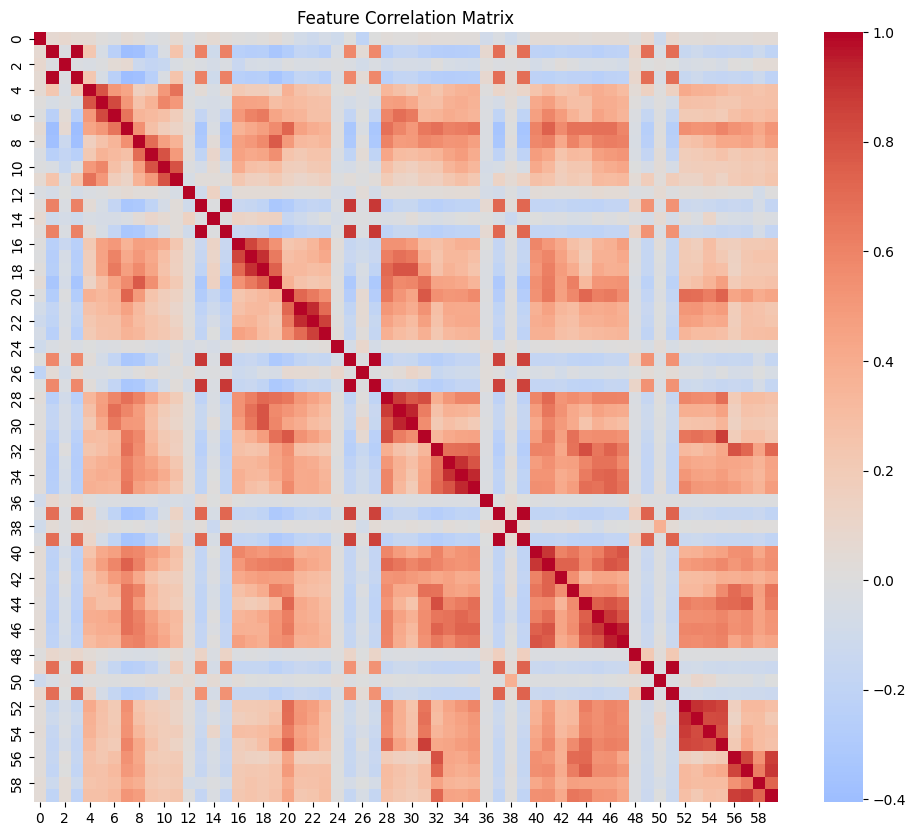

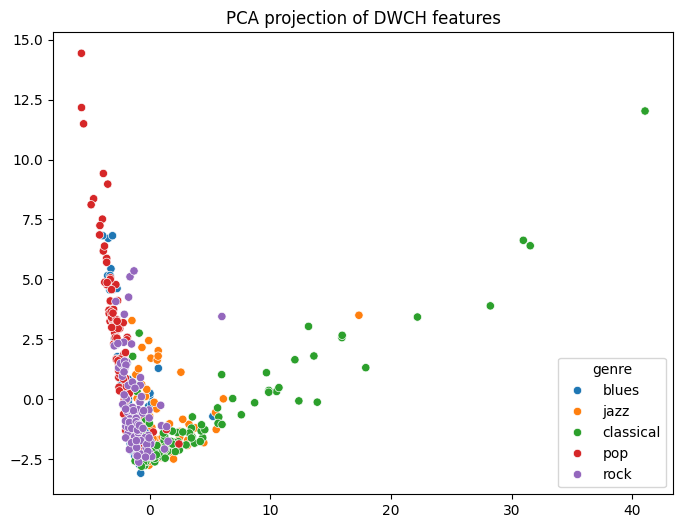

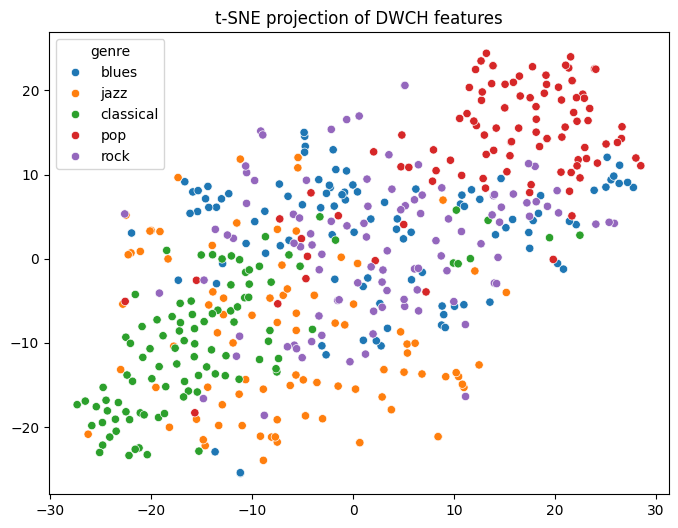

In [32]:
import os
import numpy as np
import pandas as pd
import librosa
import pywt
from scipy.stats import skew
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# ----------------------------
# 1. DWCH 特徵提取函數
# ----------------------------
def extract_DWCH_features(y, n=8, wavelet='db4', level=4):
    try:
        coeffs = pywt.wavedec(y, wavelet=wavelet, level=level)
        feature_vector = []
        for band in coeffs:
            band = np.nan_to_num(band)
            hist, _ = np.histogram(band, bins=n, density=True)
            mean_val = np.mean(band)
            var_val = np.var(band)
            skew_val = skew(band)
            energy_val = np.sum(band ** 2)
            band_features = np.concatenate(([mean_val, var_val, skew_val, energy_val], hist))
            feature_vector.extend(band_features)
        return np.array(feature_vector)
    except Exception:
        return np.zeros(4 + n * level)

# ----------------------------
# 2. 讀取音訊資料並提取 DWCH 特徵
# ----------------------------
genres = ['blues', 'jazz', 'classical', 'pop', 'rock']
DATASET_PATH = "C:\\Users\\user\\Desktop\\碩士二年級\\Python\\論文CODE\\Data\\genres_original"
X, y_labels = [], []

for genre in genres:
    folder = os.path.join(DATASET_PATH, genre)
    for file in os.listdir(folder):
        if file.endswith(".wav"):
            file_path = os.path.join(folder, file)
            y, sr = librosa.load(file_path, sr=None)
            feat = extract_DWCH_features(y, wavelet='db4', level=4)
            X.append(feat)
            y_labels.append(genre)

X = np.array(X)
y_labels = np.array(y_labels)

# ----------------------------
# 3. 封裝成 DataFrame
# ----------------------------
df = pd.DataFrame(X)
df['genre'] = y_labels

# ----------------------------
# 4. 基本統計與缺失值檢查
# ----------------------------
print("缺失值總數:", df.isnull().sum().sum())

# ----------------------------
# 6. 特徵相關性矩陣
# ----------------------------
plt.figure(figsize=(12,10))
corr = df.drop(columns='genre').corr()
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

# ----------------------------
# 7. 高維降維可視化 (PCA + t-SNE)
# ----------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop(columns='genre'))

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['genre'], palette='tab10')
plt.title('PCA projection of DWCH features')
plt.show()

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=df['genre'], palette='tab10')
plt.title('t-SNE projection of DWCH features')
plt.show()


### 和弦特徵

In [13]:
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from collections import Counter
import scipy.ndimage
# === 參數設定 ===
DATASET_PATH = "C:\\Users\\user\\Desktop\\碩士二年級\\Python\\論文CODE\\Data\\genres_original"
genres = ['blues', 'classical', 'jazz', 'pop', 'rock']
texture_window = 3.0  # 每段3秒
overlap = 0.5         # 50%重疊

# === 提取單段和弦特徵 ===
def extract_chord_from_segment(y_segment, sr):
    chroma = librosa.feature.chroma_stft(y=y_segment, sr=sr, n_fft=4096, hop_length=512)
    chroma = np.nan_to_num(chroma)

    chroma_smooth = scipy.ndimage.median_filter(chroma, size=(1, 9))
    chroma_mean = np.mean(chroma_smooth, axis=1)
    tonic_idx = np.argmax(chroma_mean)

    chroma_mean = np.mean(chroma, axis=1)
    tonic_idx = np.argmax(chroma_mean)

    # 根據大三度/小三度判定大調或小調
    if chroma_mean[(tonic_idx + 4) % 12] > chroma_mean[(tonic_idx + 3) % 12]:
        chord_type = 'major'
    else:
        chord_type = 'minor'

    note_names = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']
    return note_names[tonic_idx] + ('m' if chord_type == 'minor' else '')

# === 處理單首歌曲 ===
def process_audio_file(file_path):
    y, sr = librosa.load(file_path, sr=None)
    texture_samples = int(texture_window * sr)
    hop_samples = int(texture_samples * (1 - overlap))
    chords = []
    for start in range(0, len(y) - texture_samples, hop_samples):
        segment = y[start:start + texture_samples]
        chord = extract_chord_from_segment(segment, sr)
        chords.append(chord)
    return chords

# === 主程式：處理整個資料集 ===
results = []

for genre in genres:
    genre_path = os.path.join(DATASET_PATH, genre)
    for file in os.listdir(genre_path):
        if file.endswith(".wav"):
            file_path = os.path.join(genre_path, file)
            try:
                chords = process_audio_file(file_path)
                for chord in chords:
                    results.append({'genre': genre, 'file': file, 'chord': chord})
            except Exception as e:
                print(f"⚠️ Error processing {file_path}: {e}")


# === 統計每種曲風的和弦比例 ===
chord_names = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B',
               'Cm','C#m','Dm','D#m','Em','Fm','F#m','Gm','G#m','Am','A#m','Bm']

chord_ratio_matrix = []
for genre in genres:
    df_genre = df[df['genre'] == genre]
    chord_counts = Counter(df_genre['chord'])
    total = sum(chord_counts.values())
    ratios = [chord_counts.get(ch, 0) / total if total > 0 else 0 for ch in chord_names]
    chord_ratio_matrix.append(ratios)

ratio_df = pd.DataFrame(chord_ratio_matrix, index=genres, columns=chord_names)

# === 畫出五個圓餅圖（前 8 名和弦）===
plt.figure(figsize=(22, 5))

for i, genre in enumerate(genres):
    plt.subplot(1, 5, i + 1)
    ratios = ratio_df.loc[genre]
    
    # 取前 8 大和弦
    top_chords = ratios.sort_values(ascending=False)[:8]
    
    # 每張圖 8 種顏色（固定色系 tab10 或 tab20）
    colors = plt.cm.tab10(np.linspace(0, 1, 8))  
    
    plt.pie(
        top_chords, 
        labels=top_chords.index, 
        autopct='%1.1f%%',
        startangle=90, 
        colors=colors, 
        textprops={'fontsize': 9}
    )
    plt.title(genre.capitalize(), fontsize=13)

plt.suptitle("Chord Proportion (Top 8) by Genre", fontsize=16)
plt.tight_layout()
plt.show()


c:\Users\user\anaconda3\envs\py310\lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


KeyboardInterrupt: 

In [33]:
!pip install hmmlearn

c:\Users\user\anaconda3\envs\py310\lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


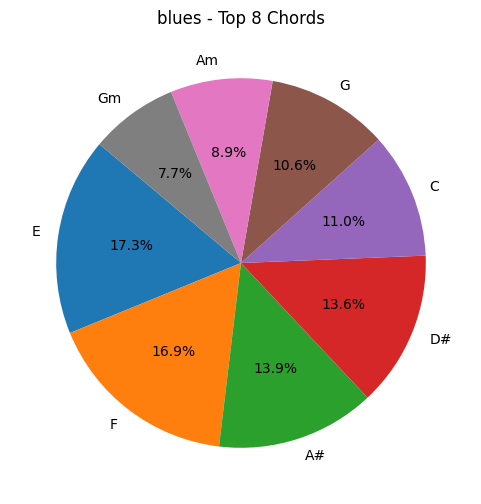

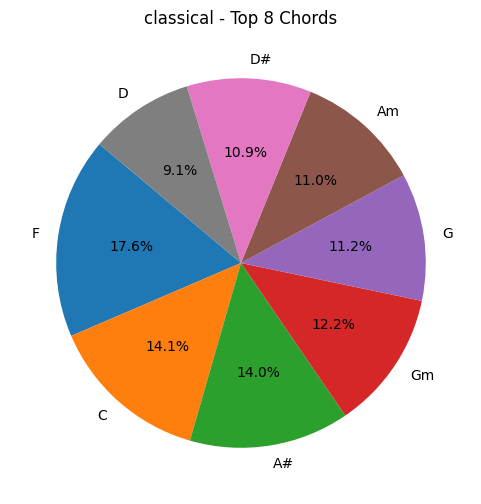

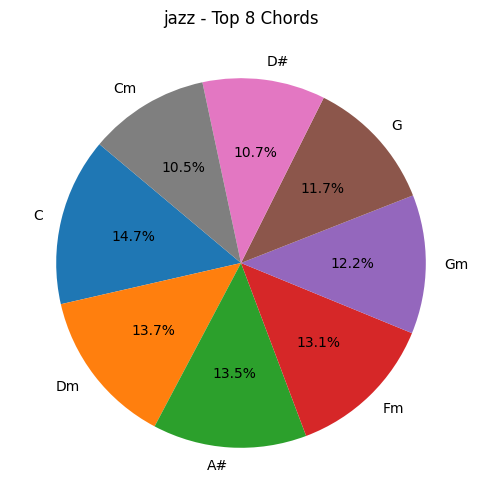

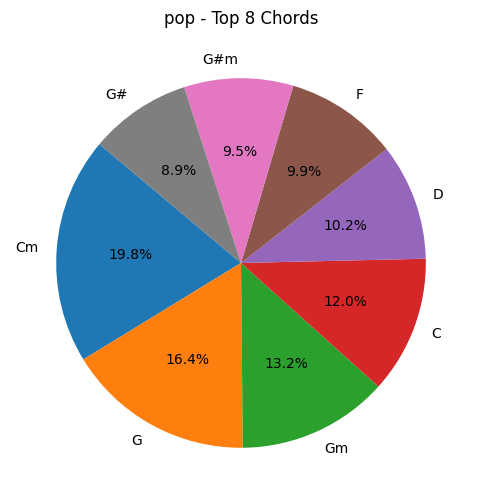

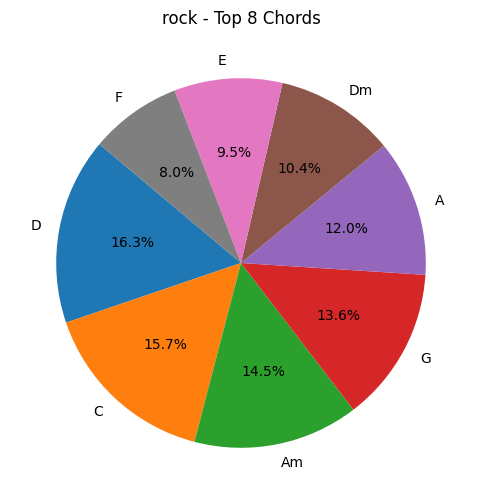

In [34]:
import os
import numpy as np
import librosa
from collections import Counter, defaultdict
import matplotlib.pyplot as plt

# === 參數設定 ===
DATASET_PATH = "C:\\Users\\user\\Desktop\\碩士二年級\\Python\\論文CODE\\Data\\genres_original"
genres = ['blues', 'classical', 'jazz', 'pop', 'rock']
texture_window = 3.0  # 每段 3 秒
overlap = 0.5         # 50%重疊
sr_target = 22050

# === 和弦模板（24 和弦: 12 大調 + 12 小調）===
note_names = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']
chord_names = [n for n in note_names] + [n+'m' for n in note_names]

def build_chord_templates():
    templates = {}
    for i, note in enumerate(note_names):
        major = np.zeros(12)
        minor = np.zeros(12)
        major[i] = 1
        major[(i+4)%12] = 1
        major[(i+7)%12] = 1
        minor[i] = 1
        minor[(i+3)%12] = 1
        minor[(i+7)%12] = 1
        templates[note] = major
        templates[note+'m'] = minor
    return templates

chord_templates = build_chord_templates()

# === 計算 chroma 與模板相似度 ===
def chroma_to_chord(chroma_mean):
    sims = []
    for chord in chord_names:
        template = chord_templates[chord]
        sim = np.dot(chroma_mean, template) / (np.linalg.norm(chroma_mean) * np.linalg.norm(template) + 1e-6)
        sims.append(sim)
    idx = np.argmax(sims)
    return chord_names[idx]

# === 處理單首歌 ===
def process_audio_file(file_path):
    y, sr = librosa.load(file_path, sr=sr_target)
    texture_samples = int(texture_window * sr)
    hop_samples = int(texture_samples * (1-overlap))
    chord_seq = []

    for start in range(0, len(y)-texture_samples, hop_samples):
        segment = y[start:start+texture_samples]
        chroma = librosa.feature.chroma_stft(y=segment, sr=sr, n_fft=4096, hop_length=512)
        chroma = np.nan_to_num(chroma)
        chroma_mean = np.mean(chroma, axis=1)
        chord = chroma_to_chord(chroma_mean)
        chord_seq.append(chord)
    
    return chord_seq

# === 滑動窗口平滑 ===
def smooth_chords(chord_seq, window=3):
    smoothed = []
    for i in range(len(chord_seq)):
        start = max(0, i - window//2)
        end = min(len(chord_seq), i + window//2 + 1)
        counts = Counter(chord_seq[start:end])
        smoothed.append(counts.most_common(1)[0][0])
    return smoothed

# === 處理整個資料集 ===
genre_chords = defaultdict(list)

for genre in genres:
    genre_path = os.path.join(DATASET_PATH, genre)
    for file in os.listdir(genre_path):
        if file.endswith(".wav"):
            file_path = os.path.join(genre_path, file)
            try:
                chord_seq = process_audio_file(file_path)
                chord_seq = smooth_chords(chord_seq, window=3)
                genre_chords[genre].extend(chord_seq)
            except Exception as e:
                print(f"Error processing {file_path}: {e}")

# === 畫圓餅圖（每個曲風前 8 和弦）===
for genre in genres:
    c = Counter(genre_chords[genre])
    most_common = c.most_common(8)
    labels, counts = zip(*most_common)
    plt.figure(figsize=(6,6))
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(f"{genre} - Top 8 Chords")
    plt.show()


In [37]:
import os
import numpy as np
import librosa
from collections import Counter, defaultdict

# ======== 參數 ========
texture_window = 3.0
overlap = 0.5
sr_target = 22050
analysis_window = 0.1  # 0.1 秒
genres = ['blues', 'classical', 'jazz', 'pop', 'rock']
note_names = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']
chord_names = [n for n in note_names] + [n+'m' for n in note_names]

# ======== 和弦模板 ========
def build_chord_templates():
    templates = {}
    for i, note in enumerate(note_names):
        major = np.zeros(12)
        minor = np.zeros(12)
        major[i] = 1
        major[(i+4)%12] = 1
        major[(i+7)%12] = 1
        minor[i] = 1
        minor[(i+3)%12] = 1
        minor[(i+7)%12] = 1
        templates[note] = major
        templates[note+'m'] = minor
    return templates
chord_templates = build_chord_templates()

def chroma_to_chord(chroma_mean):
    sims = []
    for chord in chord_names:
        template = chord_templates[chord]
        sim = np.dot(chroma_mean, template) / (np.linalg.norm(chroma_mean) * np.linalg.norm(template) + 1e-6)
        sims.append(sim)
    idx = np.argmax(sims)
    return chord_names[idx]

# ======== Swing 特徵 ========
def extract_swing_features(y, sr):
    try:
        tempo, beats = librosa.beat.beat_track(y=y, sr=sr)
        onsets = librosa.onset.onset_detect(y=y, sr=sr, units='time')
        if len(onsets) < 3:
            return np.zeros(4)
        intervals = np.diff(onsets)
        ratios = intervals[1:] / (intervals[:-1] + 1e-6)
        swing_mean = np.mean(ratios)
        swing_var = np.var(ratios)
        rms = librosa.feature.rms(y=y)[0]
        rms_mean = np.mean(rms)
        rms_var = np.var(rms)
        return np.array([swing_mean, swing_var, rms_mean, rms_var])
    except:
        return np.zeros(4)

# ======== Analysis 特徵 ========
def extract_analysis_features(y_segment, sr):
    centroid = librosa.feature.spectral_centroid(y=y_segment, sr=sr)[0]
    rolloff = librosa.feature.spectral_rolloff(y=y_segment, sr=sr)[0]
    zcr = librosa.feature.zero_crossing_rate(y=y_segment)[0]
    feats = {
        'centroid_mean': np.mean(centroid),
        'centroid_var': np.var(centroid),
        'rolloff_mean': np.mean(rolloff),
        'rolloff_var': np.var(rolloff),
        'zcr_mean': np.mean(zcr),
        'zcr_var': np.var(zcr)
    }
    return feats

# ======== Texture 特徵 ========
def extract_texture_features(y_segment, sr):
    analysis_len = int(analysis_window * sr)
    hop_len = int(0.5 * sr)
    total_len = len(y_segment)

    # analysis features
    starts = np.arange(0, max(total_len - analysis_len + 1, 1), hop_len, dtype=int)
    analysis_features_list = [extract_analysis_features(y_segment[start:start+analysis_len], sr) for start in starts]

    # 計算 mean/var
    all_feats = {}
    for key in analysis_features_list[0].keys():
        values = np.array([f[key] for f in analysis_features_list])
        all_feats[key] = np.mean(values)  # 已經是 mean/var
        all_feats[key.replace('mean','var')] = np.var(values)

    # MFCC + Swing 直接用 texture window
    mfcc = librosa.feature.mfcc(y=y_segment, sr=sr, n_mfcc=13)
    all_feats.update({
        **{f'mfcc{i+1}_mean': np.mean(mfcc[i]) for i in range(13)},
        **{f'mfcc{i+1}_var': np.var(mfcc[i]) for i in range(13)}
    })
    swing_feats = extract_swing_features(y_segment, sr)
    all_feats['swing_mean'] = swing_feats[0]
    all_feats['swing_var']  = swing_feats[1]
    all_feats['rms_mean']   = swing_feats[2]
    all_feats['rms_var']    = swing_feats[3]

    return np.hstack(list(all_feats.values()))

# ======== 和弦特徵 ========
def extract_chord_features(y, sr):
    texture_samples = int(texture_window * sr)
    hop_samples = int(texture_samples * (1-overlap))
    chord_seq = []
    for start in range(0, len(y)-texture_samples, hop_samples):
        segment = y[start:start+texture_samples]
        chroma = librosa.feature.chroma_stft(y=segment, sr=sr, n_fft=4096, hop_length=512)
        chroma = np.nan_to_num(chroma)
        chord = chroma_to_chord(np.mean(chroma, axis=1))
        chord_seq.append(chord)
    c = Counter(chord_seq)
    chord_vector = np.array([c[ch]/len(chord_seq) if len(chord_seq)>0 else 0 for ch in chord_names])
    return chord_vector

# ======== 整合特徵 ========
def extract_combined_features(file_path):
    y, sr = librosa.load(file_path, sr=sr_target)
    texture_feats = extract_texture_features(y, sr)
    chord_feats = extract_chord_features(y, sr)
    combined = np.hstack([texture_feats, chord_feats])
    return combined


In [39]:
import os
import numpy as np
import librosa
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report

# ======== 參數 ========
DATASET_PATH = "C:\\Users\\user\\Desktop\\碩士二年級\\Python\\論文CODE\\Data\\genres_original"
genres = ['blues', 'classical', 'jazz', 'pop', 'rock']
sr_target = 22050

# ======== 先前定義的特徵提取函式 ========
# extract_combined_features(file_path) 需已經定義好

# ======== 1. 遍歷資料集 ========
X = []
y = []

for label, genre in enumerate(genres):
    genre_path = os.path.join(DATASET_PATH, genre)
    for file in os.listdir(genre_path):
        if file.endswith(".wav"):
            file_path = os.path.join(genre_path, file)
            try:
                feats = extract_combined_features(file_path)
                X.append(feats)
                y.append(label)
            except Exception as e:
                print(f"❌ 無法處理 {file_path}: {e}")

X = np.array(X)
y = np.array(y)

print(f"資料集大小: {X.shape}, 標籤大小: {y.shape}")

# ======== 2. 特徵標準化 ========
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ======== 3. Logistic Regression 分類 + 5-fold 交叉驗證 ========
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
acc_scores = []

for train_idx, test_idx in kf.split(X_scaled, y):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    clf = LogisticRegression(max_iter=500, multi_class='multinomial', solver='lbfgs')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    acc_scores.append(acc)
    print(classification_report(y_test, y_pred, target_names=genres))

print(f"平均交叉驗證準確率: {np.mean(acc_scores):.4f} ± {np.std(acc_scores):.4f}")



c:\Users\user\anaconda3\envs\py310\lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


資料集大小: (499, 60), 標籤大小: (499,)
              precision    recall  f1-score   support

       blues       0.67      0.90      0.77        20
   classical       0.94      0.85      0.89        20
        jazz       0.79      0.75      0.77        20
         pop       0.94      0.85      0.89        20
        rock       0.78      0.70      0.74        20

    accuracy                           0.81       100
   macro avg       0.82      0.81      0.81       100
weighted avg       0.82      0.81      0.81       100

              precision    recall  f1-score   support

       blues       0.81      0.85      0.83        20
   classical       0.95      1.00      0.98        20
        jazz       0.74      0.85      0.79        20
         pop       1.00      0.90      0.95        20
        rock       0.71      0.60      0.65        20

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84   

c:\Users\user\anaconda3\envs\py310\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\user\anaconda3\envs\py310\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\user\anaconda3\envs\py310\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\user\anaconda3\envs\py310\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning